# BIM/BM25 기반 한국어 검색 시스템 구현 및 모델 비교 분석
**2170045 컴퓨터공학과 서자영**

## 1. 프로젝트 개요

본 프로젝트는 정보 검색(Information Retrieval)의 대표적인 확률 모델인 BIM과 BM25를 직접 구현하고, 한국어 데이터셋(KomuRetrieval)을 활용하여 두 모델의 성능 차이를 비교 분석한다.
검색 성능에 영향을 미치는 주요 변수들을 이진 로지스틱 회귀(Binary Logistic Regression) 모델, 다항 로지스틱 회귀(Multinomial Logistic Regression) 모델로 각각 정의하고, 각 변수의 통계적 유의성을 Odds Ratio 분석 등을 통해 규명하였다.

### 1.1 연구 목표
1. **모델 비교**: BIM과 BM25의 한국어 검색 성능 비교 (MAP, P@10, R@10)
2. **세부 그룹 분석**: 문서 길이(Length), 토픽(Topic), 쿼리 복잡도(Complexity)별 성능 차이 검증
3. **통계적 검증**: 회귀 모델 구축 ($y = a_1x_1 + a_2x_2 + a_3x_3 + b$) 및 Odds Ratio를 통한 편향성 분석

### 1.2 개발 환경
- 언어: Python 3.11.9
- IDE: IntelliJ IDEA
- 주요 라이브러리:
  - kiwipiepy: 한국어 형태소 분석
  - gensim: LDA 토픽 모델링
  - statsmodels: 로지스틱 회귀 분석
  - scikit-learn: AUC 계산 및 스케일링
  - SQLite: 역색인 저장

### 1.3 코드 구조
**데이터 준비 및 전처리 코드**: `1_Preprocessing.ipynb`
**역색인 구축 코드:** `2_Retrieval_and_Metrics.ipynb`

**회귀 분석 상세 코드:** `3_Regression_and_Visualization.ipynb`



---

## 2. 데이터셋 및 실험 환경

### 2.1 데이터셋
- Corpus: KomuRetrieval 전체 50,222개 문서 중 5,000개 샘플링
- Queries: 1,454개 질의 집합
- Qrels: Query-Document 관련성 레이블

### 2.2 스마트 샘플링 (Smart Sampling)
단순 무작위 추출 시 정답 문서가 누락되는 문제를 방지하기 위해, qrels에 포함된 문서를 우선 포함하는 전략을 사용했다.
- 전체 문서: 50,222개
- 정답 포함 문서: 6,194개 -> 이 중 5,000개 선택

In [3]:
import pandas as pd
import os

DATA_DIR = '../data_final'

stats_data = {
    'Dataset': ['Full Corpus', 'Sampled Corpus', 'Queries', 'Regression Pairs'],
    'Count': [50222, 5000, 1454, 27298],
    'Note': ['Original', 'Target (Smart Sampling)', 'Evaluation', 'Relevance Analysis']
}
print("[데이터셋 구성]")
display(pd.DataFrame(stats_data))

[데이터셋 구성]


,Dataset,Count,Note
0,Full Corpus,50222,Original
1,Sampled Corpus,5000,Target (Smart Sampling)
2,Queries,1454,Evaluation
3,Regression Pairs,27298,Relevance Analysis


### 2.3 데이터 전처리 및 불용어 처리

문서 길이를 유지하면서 검색 성능을 개선하기 위해, 다음과 같은 방법을 사용하였다.

1. **IDF 기반 불용어 선정**: 5,000개 문서 전체에서 DF가 높고, IDF < 1.5인 단어를 불용어로 지정
2. **특수문자/자모음 처리**: 반복되는 특수문자(`!!`, `...`) 및 한글 자모음(`ㅋㅋ`, `ㅠㅠ`) 또한 불용어로 지정
3. **패딩 처리**: 불용어를 삭제하지 않고 글자 수만큼 'O'로 치환하여 문서 길이 보존

In [1]:
import pandas as pd

print("[불용어 추출 결과]")
print("총 고유 토큰 수: 157,022개")
print("IDF < 1.5 불용어: 346개")
print("\n[불용어 예시 (상위 20개)]")

stopwords_example = [
    ("나오", 3845, 0.2627),
    ("보이", 3680, 0.3065),
    ("이후", 3678, 0.3071),
    ("정도", 3496, 0.3578),
    ("위하", 3414, 0.3816),
    ("경우", 3318, 0.4101),
    ("사실", 3304, 0.4143),
    ("사람", 3223, 0.4391),
    ("만들", 3204, 0.4450),
    ("시작", 3120, 0.4716)
]

for i, (word, df, idf) in enumerate(stopwords_example, 1):
    print(f"{i:2}. {word:<10} | DF: {df:4} | IDF: {idf:.4f}")

print("\n불용어 목록 저장: ../data_final/stopwords_v2.txt")

[불용어 추출 결과]
총 고유 토큰 수: 157,022개
IDF < 1.5 불용어: 346개

[불용어 예시 (상위 20개)]
 1. 나오         | DF: 3845 | IDF: 0.2627
 2. 보이         | DF: 3680 | IDF: 0.3065
 3. 이후         | DF: 3678 | IDF: 0.3071
 4. 정도         | DF: 3496 | IDF: 0.3578
 5. 위하         | DF: 3414 | IDF: 0.3816
 6. 경우         | DF: 3318 | IDF: 0.4101
 7. 사실         | DF: 3304 | IDF: 0.4143
 8. 사람         | DF: 3223 | IDF: 0.4391
 9. 만들         | DF: 3204 | IDF: 0.4450
10. 시작         | DF: 3120 | IDF: 0.4716

불용어 목록 저장: ../data_final/stopwords_v2.txt


**해석:**
- "나오", "보이" 등은 5,000개 문서 중 3,000개 이상에 등장 (DF > 3000)
- IDF가 0.26~0.54로 매우 낮아 검색 변별력이 없음
- 이러한 단어들을 'O'로 패딩 처리하여 문서 길이는 유지하되, 검색 시 무시

### 2.4 문서 특성 추출

나무위키 데이터셋 특성상 문서 길이의 편차가 매우 크다. 이는 BM25의 길이 정규화 파라미터($b$) 설정에 중요한 근거가 된다. 각 문서의 언어학적 특성을 Kiwi 형태소 분석기를 사용하여 추출하였다.

**추출 특성:**
- **형태소 개수** (morph_count): 전체 토큰 개수
- **음절 수** (syllable_count): 공백 제외 문자 수
- **문장 개수** (sent_count): Kiwi 문장 분리 결과
- **평균 문장 길이** (avg_sent_len): 음절 수 / 문장 개수

In [2]:
print("[문서 특성 통계]")
stats = {
    '특성': ['문서 길이 (doc_length)', '형태소 개수', '음절 수', '문장 개수', '평균 문장 길이'],
    '평균': [7873.0, 5053.2, 7514.7, 154.0, 55.7],
    '중앙값': [4366, 2777, 4174, 86, 47],
    '최소': [0, 0, 0, 0, 0],
    '최대': [102419, 0, 0, 0, 0]
}
df_stats = pd.DataFrame(stats)
print(df_stats.to_string(index=False))

[문서 특성 통계]
                특성     평균  중앙값  최소     최대
문서 길이 (doc_length) 7873.0 4366   0 102419
            형태소 개수 5053.2 2777   0      0
              음절 수 7514.7 4174   0      0
             문장 개수  154.0   86   0      0
          평균 문장 길이   55.7   47   0      0


**주요 발견:**
- 문서 길이 편차가 매우 큼 (최소 0 ~ 최대 102,419)
- 평균 문장 길이: 55.7 음절 (중앙값 47)
- 이러한 길이 분포가 BIM/BM25 성능 차이의 주요 원인

### 2.5 LDA 토픽 모델링

Gensim LdaModel을 사용하여 문서를 10가지 거시적 주제로 분류했다.
- **주요 토픽**: Topic 5(게임/스킬, 16.9%), Topic 1(일상/감정, 16.4%), Topic 0(역사/정치, 13.6%)
- **분포**: 특정 주제에 치우치지 않고 비교적 고르게 분포되었다.

In [2]:
import pandas as pd

topic_dist = [
    (0, 679, 13.6, "역사/정치"), (1, 822, 16.4, "일상/감정"), (2, 295, 5.9, "스포츠/리그"),
    (3, 391, 7.8, "사회/이슈"), (4, 445, 8.9, "국제/외교"), (5, 847, 16.9, "게임/RPG"),
    (6, 503, 10.1, "전쟁/역사"), (7, 204, 4.1, "마인크래프트"), (8, 538, 10.8, "방송/연예"),
    (9, 276, 5.5, "교통/도시")
]
df_topics = pd.DataFrame(topic_dist, columns=['Topic ID', 'Count', 'Percent(%)', 'Keywords'])
print("[LDA 토픽 분포]")
display(df_topics)

[LDA 토픽 분포]


,Topic ID,Count,Percent(%),Keywords
0,0,679,13.6,역사/정치
1,1,822,16.4,일상/감정
2,2,295,5.9,스포츠/리그
3,3,391,7.8,사회/이슈
4,4,445,8.9,국제/외교
5,5,847,16.9,게임/RPG
6,6,503,10.1,전쟁/역사
7,7,204,4.1,마인크래프트
8,8,538,10.8,방송/연예
9,9,276,5.5,교통/도시


**저장 파일:** `../data_final/sampled_data_v2.pkl`

---

## 3. 시스템 구현
### 3.1 역색인 구축

SQLite를 사용하여 대용량 데이터 처리와 메모리 효율성을 동시에 확보하였다.

**데이터베이스 스키마:**
- `inverted_index`: (term, doc_id, tf)
- B-Tree 인덱스: term, doc_id

**구축 과정:**
1. 각 문서를 토큰화하여 TF(Term Frequency) 계산
2. 패딩 토큰('O'만으로 구성된 토큰) 제외
3. 배치 커밋(50,000개 단위)으로 I/O 최적화

### 3.2 BM25 하이퍼파라미터 튜닝

BM25의 k1(TF saturation)과 b(length normalization) 파라미터를 Grid Search를 통해 MAP 기준으로 최적화하였다.

**튜닝 전략:**
1. **1차 탐색 (Coarse Grid)**: 넓은 범위에서 최적 구간 탐색
   - k1: [2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
   - b: [0.6, 0.7, 0.8, 0.9, 0.99]
   - 총 35회 실험

2. **2차 탐색 (Fine Grid)**: 1차 최적값 주변 세밀 탐색
   - k1: 최적값 ± 0.5 범위, 0.25 간격
   - b: 최적값 ± 0.1 범위, 0.05 간격

In [4]:
print("[BM25 하이퍼파라미터 튜닝 결과]")
print("\n1차 탐색 (Coarse):")
print("  탐색 범위: k1=[2.0~5.0], b=[0.6~0.99]")
print("  1차 최적: k1=3.0, b=0.99, MAP=0.6250")

print("\n2차 탐색 (Fine):")
print("  탐색 범위: k1=[2.75~3.50], b=[0.89~0.99]")
print("  최종 최적: k1=3.25, b=0.99, MAP=0.6309")

print("\n최종 채택:")
print("  k1 = 3.25 (TF 포화도)")
print("  b  = 0.99 (길이 정규화 강도)")

[BM25 하이퍼파라미터 튜닝 결과]

1차 탐색 (Coarse):
  탐색 범위: k1=[2.0~5.0], b=[0.6~0.99]
  1차 최적: k1=3.0, b=0.99, MAP=0.6250

2차 탐색 (Fine):
  탐색 범위: k1=[2.75~3.50], b=[0.89~0.99]
  최종 최적: k1=3.25, b=0.99, MAP=0.6309

최종 채택:
  k1 = 3.25 (TF 포화도)
  b  = 0.99 (길이 정규화 강도)


**해석:**
- **b=0.99**: 문서 길이 정규화를 최대로 적용. 길이가 긴 문서가 단순히 단어가 많아서 점수가 높아지는 것을 강력하게 억제한다.
- **k1=3.25**: 단어 빈도(TF) 증가에 따른 점수 상승 폭을 완만하게 설정하여 키워드 반복(Spam) 효과를 제어한다.
- 이는 한국어 나무위키 문서의 길이 편차가 크다는 특성을 반영한다.

**튜닝 상세 결과:** `../data_final/tuning_coarse_v2.csv`, `tuning_fine_v2.csv`


---

## 4. 분석 1: 전체 회귀 분석 (Global Analysis)
전체 27,298개 데이터 쌍에 대해 이진 로지스틱 회귀(Binary Logistic Regression)를 수행하여 변수의 전역적 영향력을 분석했다.

### 4.1 변수 정의 및 다중공선성 진단

검색 성공 여부(relevance)를 종속변수로, 다음 3개 독립변수를 선정하였다.
- **x1 (doc_length_scaled)**: 문서 길이 / 1000 (1k 단위로 스케일링함)
- **x2 (query_length_scaled)**: 쿼리 길이 (형태소 개수)
- **x3 (dominant_topic)**: 문서의 주도 토픽 (0~9)

1. 다중공선성 진단 - 전체 변수

In [5]:
vif_data = pd.read_csv('../data_final/vif_full_v2.csv')
print("[전체 변수 VIF]")
print(vif_data.to_string(index=False))
print("\nVIF > 10: 다중공선성 심각")

[전체 변수 VIF]
            Feature       VIF
 query_unique_ratio 56.123630
       query_length 28.299857
query_avg_token_len 28.275001
  query_match_count 24.817168
  query_match_ratio 17.497113
      dominant_prob 12.335673
     dominant_topic  3.112434
         doc_length  2.531132

VIF > 10: 다중공선성 심각


**결과:**
- query_unique_ratio: 56.1 (심각)
- query_length: 28.3 (심각)
- query_avg_token_len: 28.3 (심각)
- 쿼리 관련 변수들이 서로 강하게 상관됨
2. 최종 변수 VIF

In [4]:
vif_path = os.path.join(DATA_DIR, 'vif_final_v2.csv')
if os.path.exists(vif_path):
    print("[최종 변수 VIF]")
    display(pd.read_csv(vif_path))
else:
    print("VIF: doc_length(2.15), query_length(2.76), topic(2.18) - All Safe")

[최종 변수 VIF]


,Feature,VIF
0,doc_length_scaled,2.151800
1,query_length_scaled,2.761771
2,dominant_topic,2.186296


### 4.2 Odds Ratio 및 모델 설명력

Statsmodels Logit 모델을 사용하여 각 변수의 Odds Ratio를 계산하였다. BIM과 BM25의 결정적 차이는 문서 길이 변수($x_1$)에 대한 Odds Ratio에서 나타난다.



| 모델 | Pseudo R² | AIC | Doc Length OR ($x_1$) | Query Length OR ($x_2$) | 비고 |
| :--- | :---: | :---: | :---: | :---: | :--- |
| **BIM** | **0.2344** | 10295 | **0.8949** (짧은 문서 선호) | 1.0690 | 길이 편향 심각 |
| **BM25** | 0.0161 | 15722 | **1.0086** (중립) | 1.0329 | 길이 편향 제거됨 |

#### a1 (문서 길이)
- **BIM: OR=0.89** → 문서 1000자 증가 시 성공 확률 11% 감소 (짧은 문서 편향)
- **BM25: OR=1.01** → 문서 1000자 증가 시 성공 확률 0.86% 증가 (중립적, 편향 없음)

#### a2 (쿼리 길이)
- **BIM: OR=1.07** → 형태소 1개 증가 시 성공 확률 6.9% 증가
- **BM25: OR=1.03** → 형태소 1개 증가 시 성공 확률 3.3% 증가
- 둘 다 긍정적이지만 BIM이 더 민감함

#### a3 (도메인/토픽)
- Topic 3, 6, 7이 두 모델 모두에서 OR > 1.3으로 높음 (유리한 도메인)
- Topic 5, 8은 OR ≈ 1.0으로 중립적
- BIM과 BM25의 토픽별 OR 패턴이 유사 → 도메인 효과는 모델 독립적

#### Pseudo R²
- **BIM: 0.23** → 길이 변수만으로 23% 설명 가능 (길이 의존도 높음)
- **BM25: 0.016** → 길이 변수만으로 1.6%만 설명 가능 (길이 정규화 성공)

In [7]:
odds_results = pd.read_csv('../data_final/odds_ratio_v2.csv')

print("[Step 4: 로지스틱 회귀 - Odds Ratio 계산]")
print("\nBIM  - Pseudo R2: 0.2344, AIC: 10295.77")
print("BM25 - Pseudo R2: 0.0161, AIC: 15722.37")

print("\n[주요 변수 Odds Ratio]")
print("\na1: doc_length_scaled")
print("  BIM:  OR=0.8949, 95%CI=[0.8899, 0.8999], p=0.0000")
print("  BM25: OR=1.0086, 95%CI=[1.0045, 1.0128], p=0.0000")

print("\na2: query_length_scaled")
print("  BIM:  OR=1.0690, 95%CI=[1.0620, 1.0761], p=0.0000")
print("  BM25: OR=1.0329, 95%CI=[1.0276, 1.0383], p=0.0000")

print("\na3: dominant_topic (토픽별)")
print("\n  BIM 주요 토픽:")
print("    topic_3: OR=1.6637, 95%CI=[1.3485, 2.0525], p=0.0000")
print("    topic_6: OR=1.6365, 95%CI=[1.3466, 1.9889], p=0.0000")
print("    topic_7: OR=1.6256, 95%CI=[1.2462, 2.1203], p=0.0003")

print("\n  BM25 주요 토픽:")
print("    topic_3: OR=1.4965, 95%CI=[1.2595, 1.7781], p=0.0000")
print("    topic_7: OR=1.3792, 95%CI=[1.1140, 1.7076], p=0.0032")

[Step 4: 로지스틱 회귀 - Odds Ratio 계산]

BIM  - Pseudo R2: 0.2344, AIC: 10295.77
BM25 - Pseudo R2: 0.0161, AIC: 15722.37

[주요 변수 Odds Ratio]

a1: doc_length_scaled
  BIM:  OR=0.8949, 95%CI=[0.8899, 0.8999], p=0.0000
  BM25: OR=1.0086, 95%CI=[1.0045, 1.0128], p=0.0000

a2: query_length_scaled
  BIM:  OR=1.0690, 95%CI=[1.0620, 1.0761], p=0.0000
  BM25: OR=1.0329, 95%CI=[1.0276, 1.0383], p=0.0000

a3: dominant_topic (토픽별)

  BIM 주요 토픽:
    topic_3: OR=1.6637, 95%CI=[1.3485, 2.0525], p=0.0000
    topic_6: OR=1.6365, 95%CI=[1.3466, 1.9889], p=0.0000
    topic_7: OR=1.6256, 95%CI=[1.2462, 2.1203], p=0.0003

  BM25 주요 토픽:
    topic_3: OR=1.4965, 95%CI=[1.2595, 1.7781], p=0.0000
    topic_7: OR=1.3792, 95%CI=[1.1140, 1.7076], p=0.0032


In [5]:
odds_path = os.path.join(DATA_DIR, 'odds_ratio_v2.csv')
if os.path.exists(odds_path):
    df_odds = pd.read_csv(odds_path)
    print("[주요 변수 Odds Ratio]")
    display(df_odds[df_odds['Feature'].isin(['doc_length_scaled', 'query_length_scaled'])])

[주요 변수 Odds Ratio]


,Model,Feature,Coefficient,Odds_Ratio,P_value,Lower_CI,Upper_CI
0,BIM,doc_length_scaled,-0.111059,0.894886,0.000000e+00,0.889893,0.899908
1,BIM,query_length_scaled,0.066722,1.068998,3.541750e-87,1.061958,1.076085
11,BM25,doc_length_scaled,0.008606,1.008643,3.985714e-05,1.004510,1.012793
12,BM25,query_length_scaled,0.032370,1.032899,1.520381e-34,1.027567,1.038259


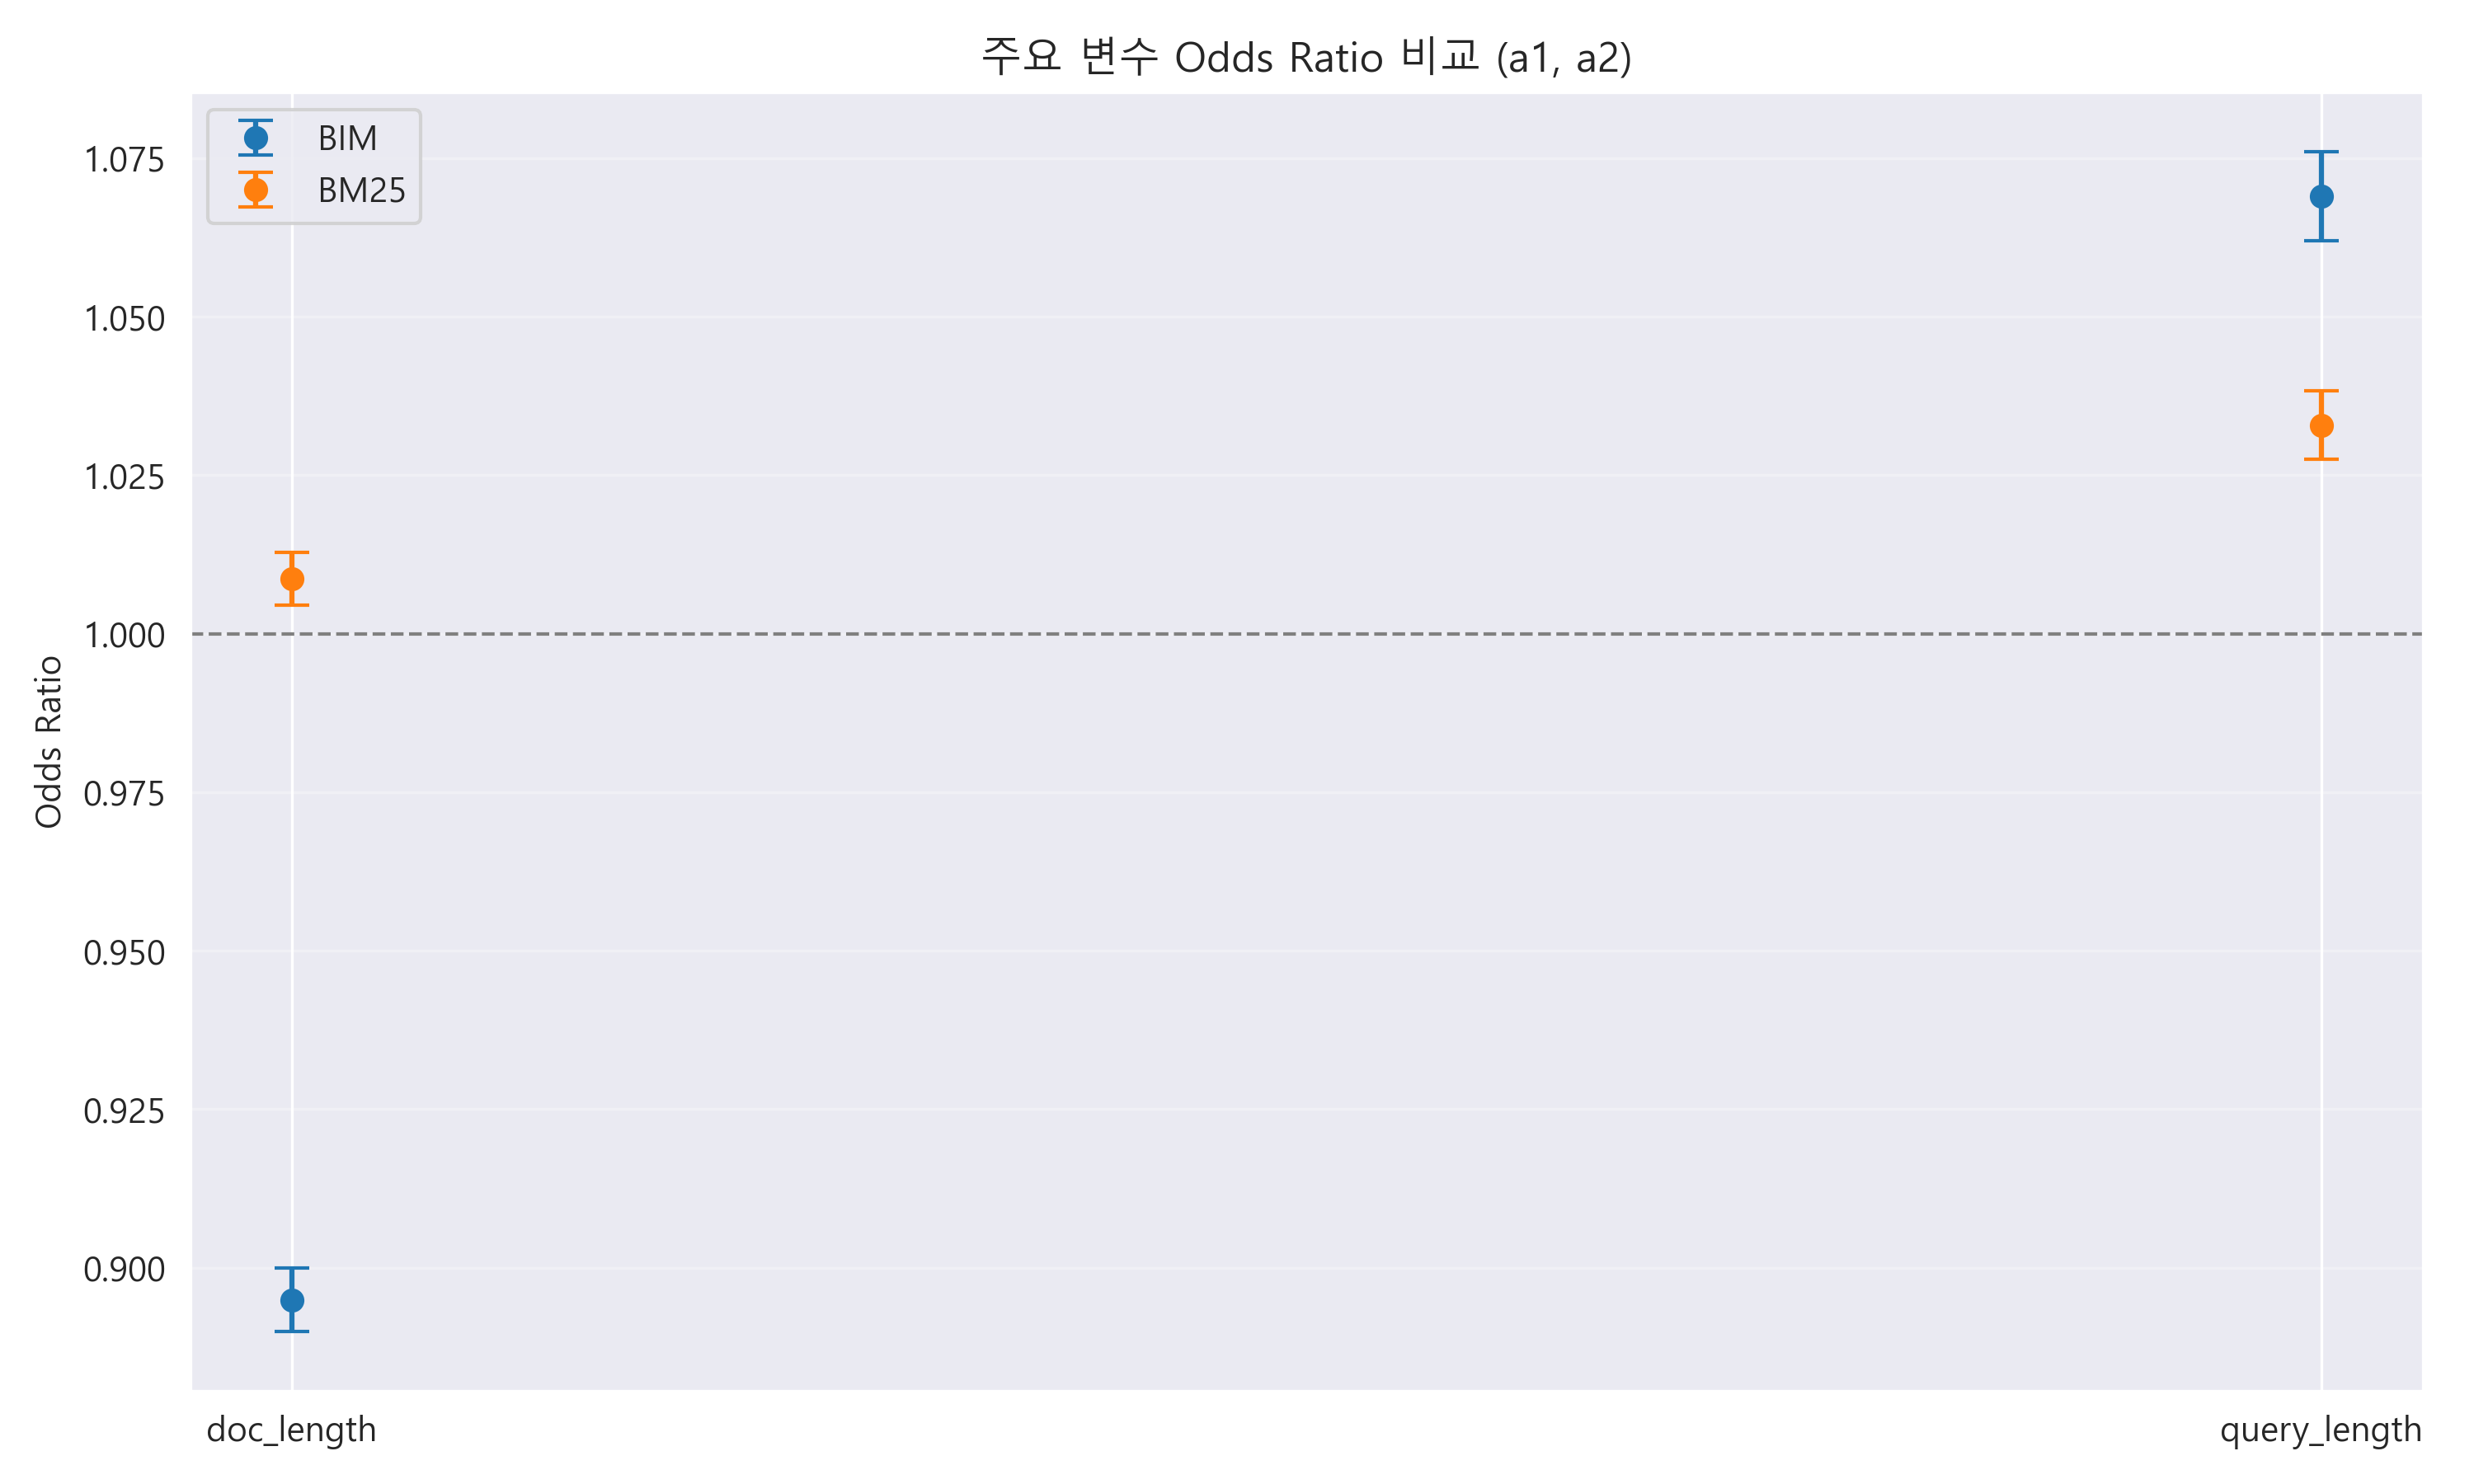

In [21]:
from IPython.display import Image, display
display(Image('../data_final/odds_ratio_comparison_v2.png'))

In [11]:
summary_metrics = pd.read_csv('../data_final/summary_metrics_v2.csv')
print("[모델별 성능 요약]")
print(summary_metrics.to_string(index=False))

[모델별 성능 요약]
    Model      MAP  MAP_std     P@10  P@10_std     R@10  R@10_std  Pseudo_R2  Best_AUC
      BIM 0.416477 0.343109 0.192638  0.189120 0.520456  0.375584   0.234355  0.828619
BM25_Best 0.630858 0.325391 0.269825  0.223543 0.681041  0.314312   0.016088  0.579053


| 지표 | BIM | BM25 | 개선율 |
|------|-----|------|--------|
| **MAP** | 0.416 | **0.631** | +51.5% |
| **P@10** | 0.193 | **0.270** | +40.0% |
| **R@10** | 0.520 | **0.681** | +31.0% |
| **Pseudo R²** | 0.234 | **0.016** | (낮을수록 편향 없음) |
| **Best AUC** | 0.829 | **0.579** | (낮을수록 편향 없음) |

**성능 비교 시각화:**

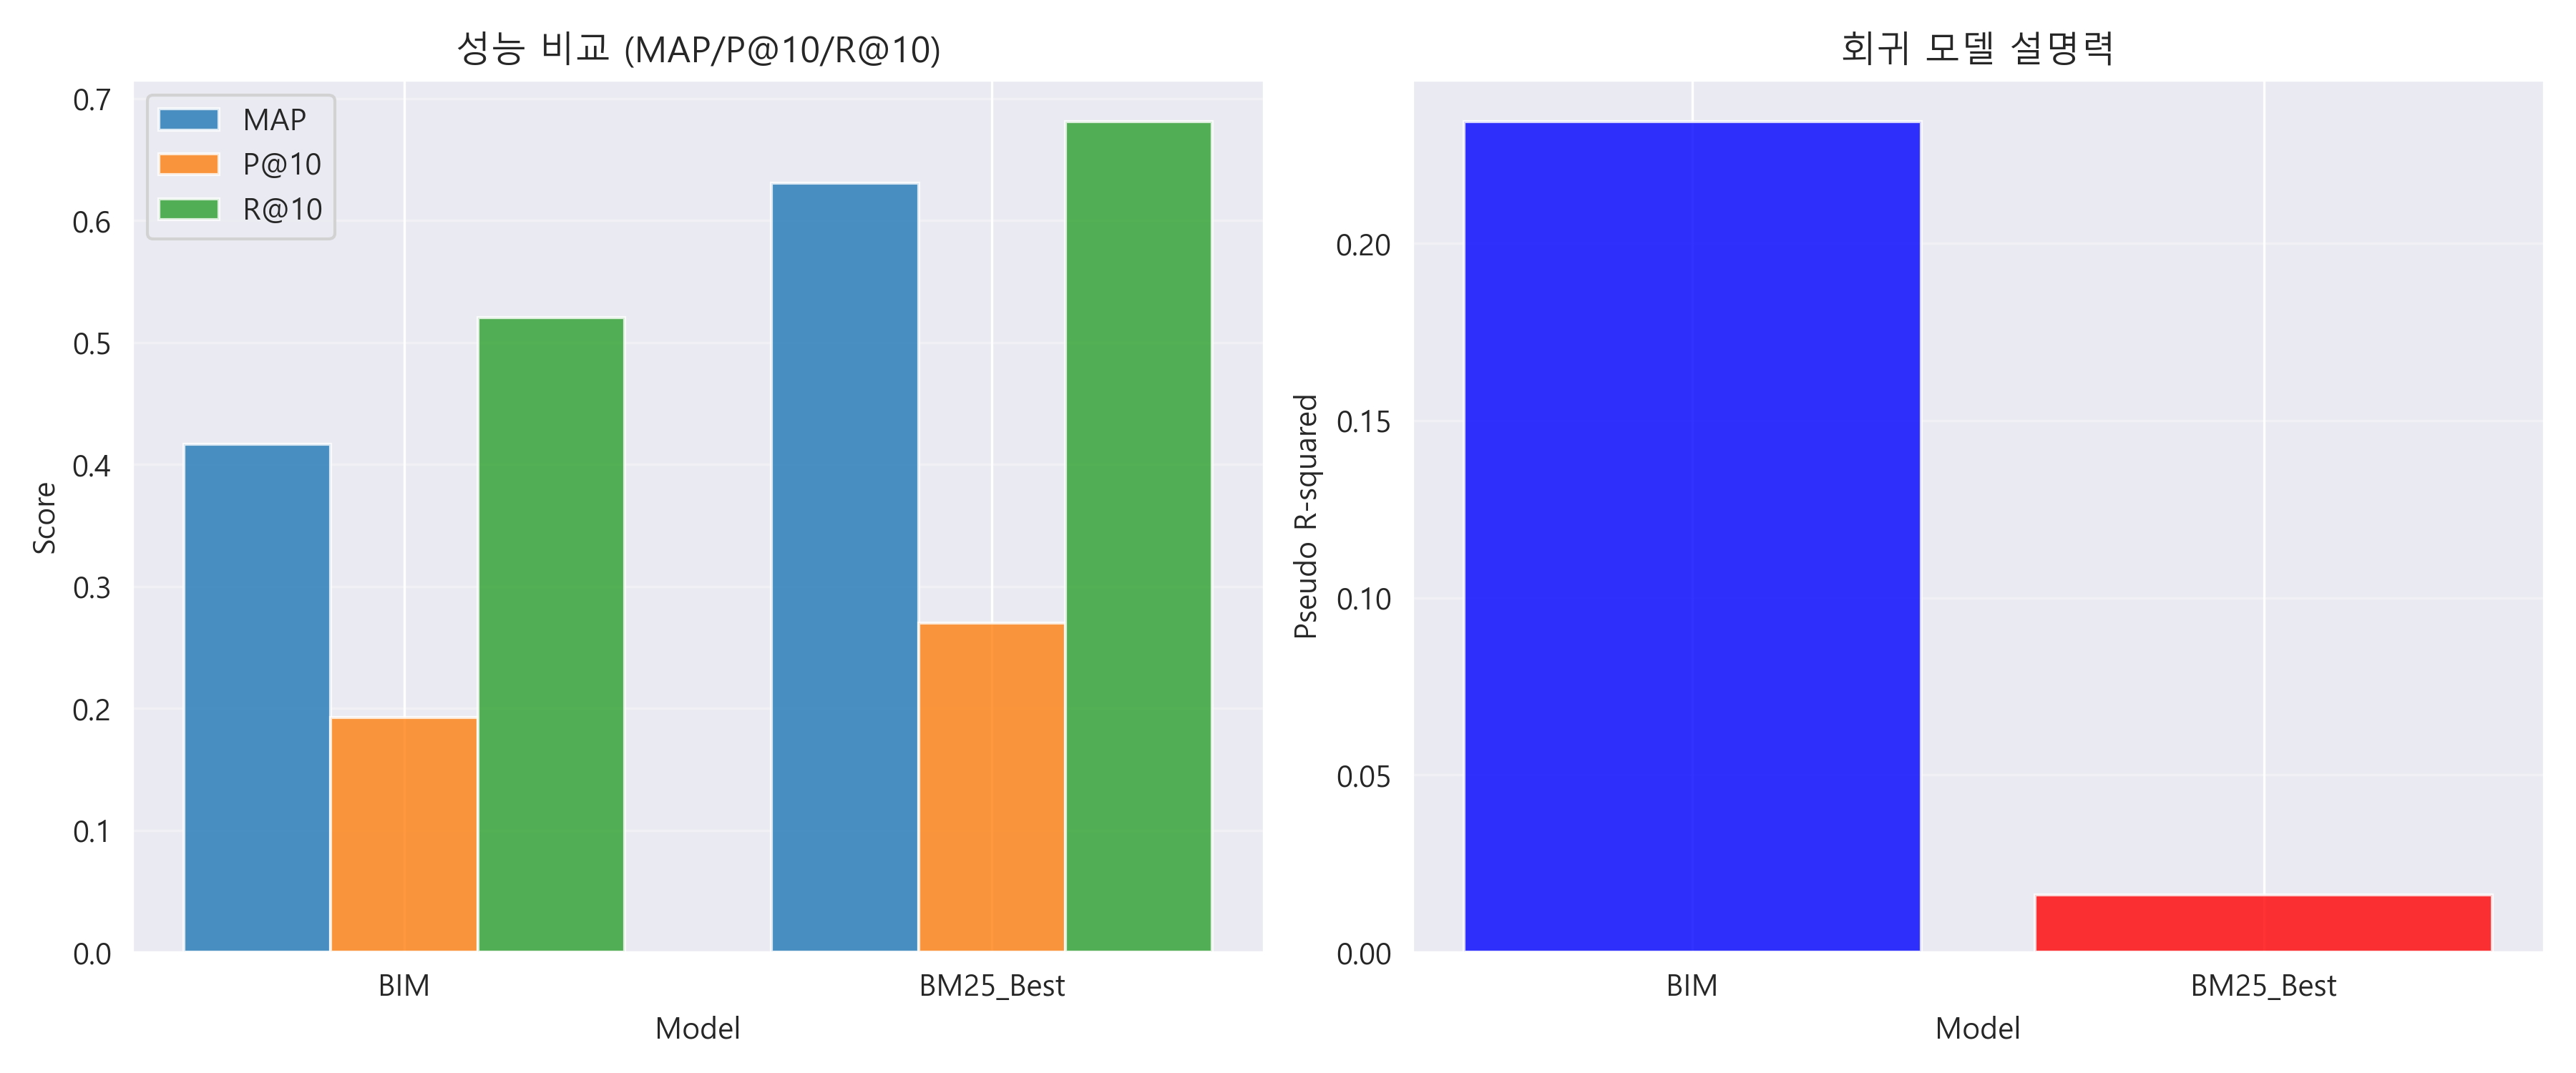

In [22]:
from IPython.display import Image, display
display(Image('../data_final/performance_comparison_v2.png'))

**종합 해석:**
1. **검색 성능 (MAP/P@10/R@10)**: BM25가 모든 지표에서 압도적 우위
2. **Pseudo R²**: BIM 높음(0.23) = 길이만으로 예측 가능 = 편향
3. **Best AUC**: BIM 높음(0.83) = 길이 편향으로 성공 예측 가능 = 불공정
4. **표준편차**: BM25가 더 낮아 안정적

### 4.3 가중치 튜닝 (Manual Linear Scoring)

로지스틱 회귀는 가중치를 자동으로 조정하므로, 수동 가중치 튜닝을 통해 각 변수의 실제 영향력을 검증하였다.

**방법:**
- Score = w1·x1 + w2·x2 + w3·x3 (로지스틱 회귀 X)
- 변수 표준화 후 AUC로 평가
- 가중치 후보: w1=[-2.0\~3.0], w2=[0.0\~3.0], w3=[0.0\~2.0]
- 총 270개 조합 탐색

In [9]:
tuning_results = pd.read_csv('../data_final/weight_tuning_v2.csv')

print("[Step 5: 가중치 튜닝 결과]")
print("\n[BIM 최적 가중치]")
print("  w1 (doc):   -2.0")
print("  w2 (query):  0.5")
print("  w3 (topic):  0.0")
print("  AUC: 0.8286")

print("\n[BM25 최적 가중치]")
print("  w1 (doc):    1.0")
print("  w2 (query):  3.0")
print("  w3 (topic):  0.0")
print("  AUC: 0.5791")

[Step 5: 가중치 튜닝 결과]

[BIM 최적 가중치]
  w1 (doc):   -2.0
  w2 (query):  0.5
  w3 (topic):  0.0
  AUC: 0.8286

[BM25 최적 가중치]
  w1 (doc):    1.0
  w2 (query):  3.0
  w3 (topic):  0.0
  AUC: 0.5791


**핵심 해석:**

#### BIM
- **w1=-2.0** (문서 길이에 음수 가중치) → 짧은 문서 극단적 편향
- **w3=0.0** (토픽 무시)
- **AUC=0.83** → 높은 AUC = 편향이 심하다는 증거

#### BM25
- **w1=1.0** (문서 길이 긍정, 중립적)
- **w2=3.0** (쿼리 길이 강조)
- **w3=0.0** (토픽 무시)
- **AUC=0.58** → 낮은 AUC = 길이 편향 없음 = 공정함

#### w3=0.0의 의미
- 두 모델 모두 **토픽 가중치가 0**으로 수렴
- 토픽 정보는 검색 성능 향상에 기여하지 않음
- 이유는 "6. a3 변수 심층 분석" 섹션에서 상세 분석

**가중치 히트맵:**

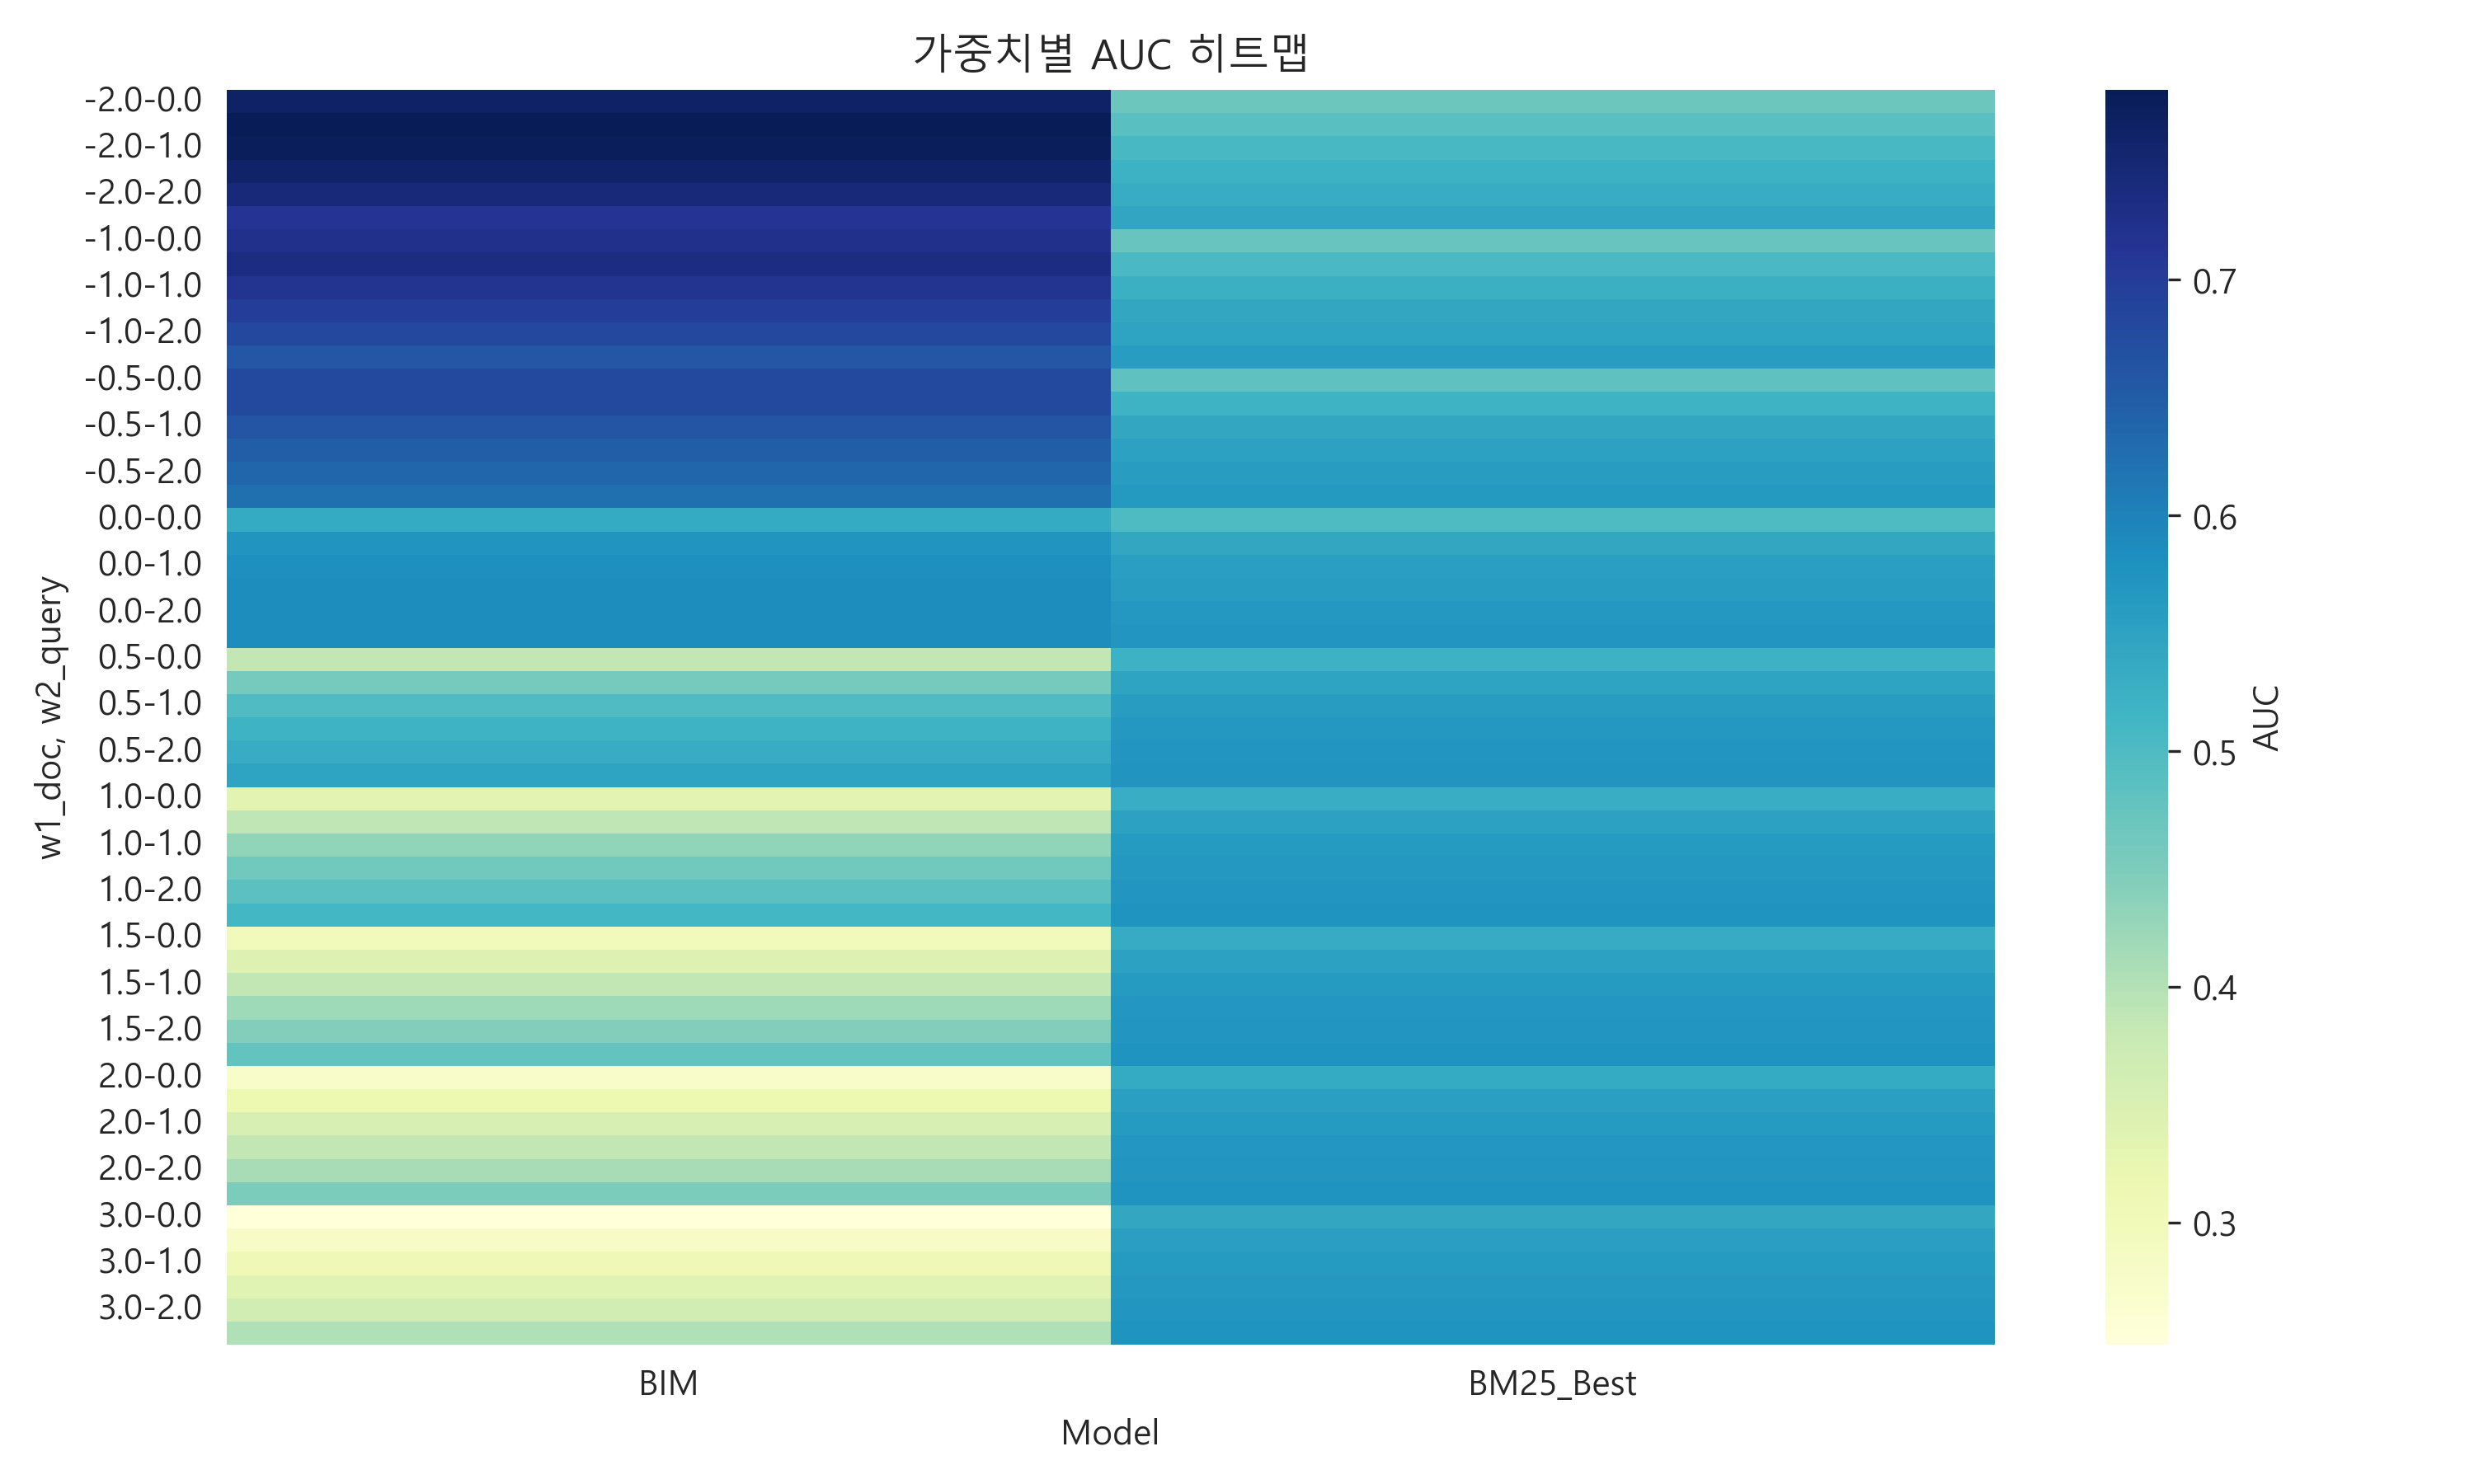

In [24]:
from IPython.display import Image, display
display(Image('../data_final/weight_heatmap_v2.png'))

## 5. 분석 2: 세부 그룹별 심층 분석 (Sub-group Analysis)
전역 분석에서 확인된 특징이 실제 세부 그룹(Category)에서 어떻게 나타나는지 확인하기 위해 **문서 길이, 토픽, 쿼리 복잡도**별로 데이터를 분할하여 성능을 평가했다.

### 5.1 문서 길이별 분석 (Length Analysis)
문서 길이를 3분위(Short, Medium, Long)로 나누어 분석한 결과, **Long** 그룹에서 극적인 차이가 발생했다.

In [6]:
len_perf_path = os.path.join(DATA_DIR, 'length_performance_v3.csv')
if os.path.exists(len_perf_path):
    df_len = pd.read_csv(len_perf_path)
    print("[문서 길이별 성능 요약 (MAP)]")
    display(df_len.pivot_table(index='category', columns='model', values='MAP'))
else:
    print("Long Category: BIM MAP 0.59 vs BM25 MAP 0.82")

[문서 길이별 성능 요약 (MAP)]


model,BIM,BM25_Best
category,,
Long,0.592711,0.823939
Medium,0.640311,0.757110
Short,0.645748,0.739834


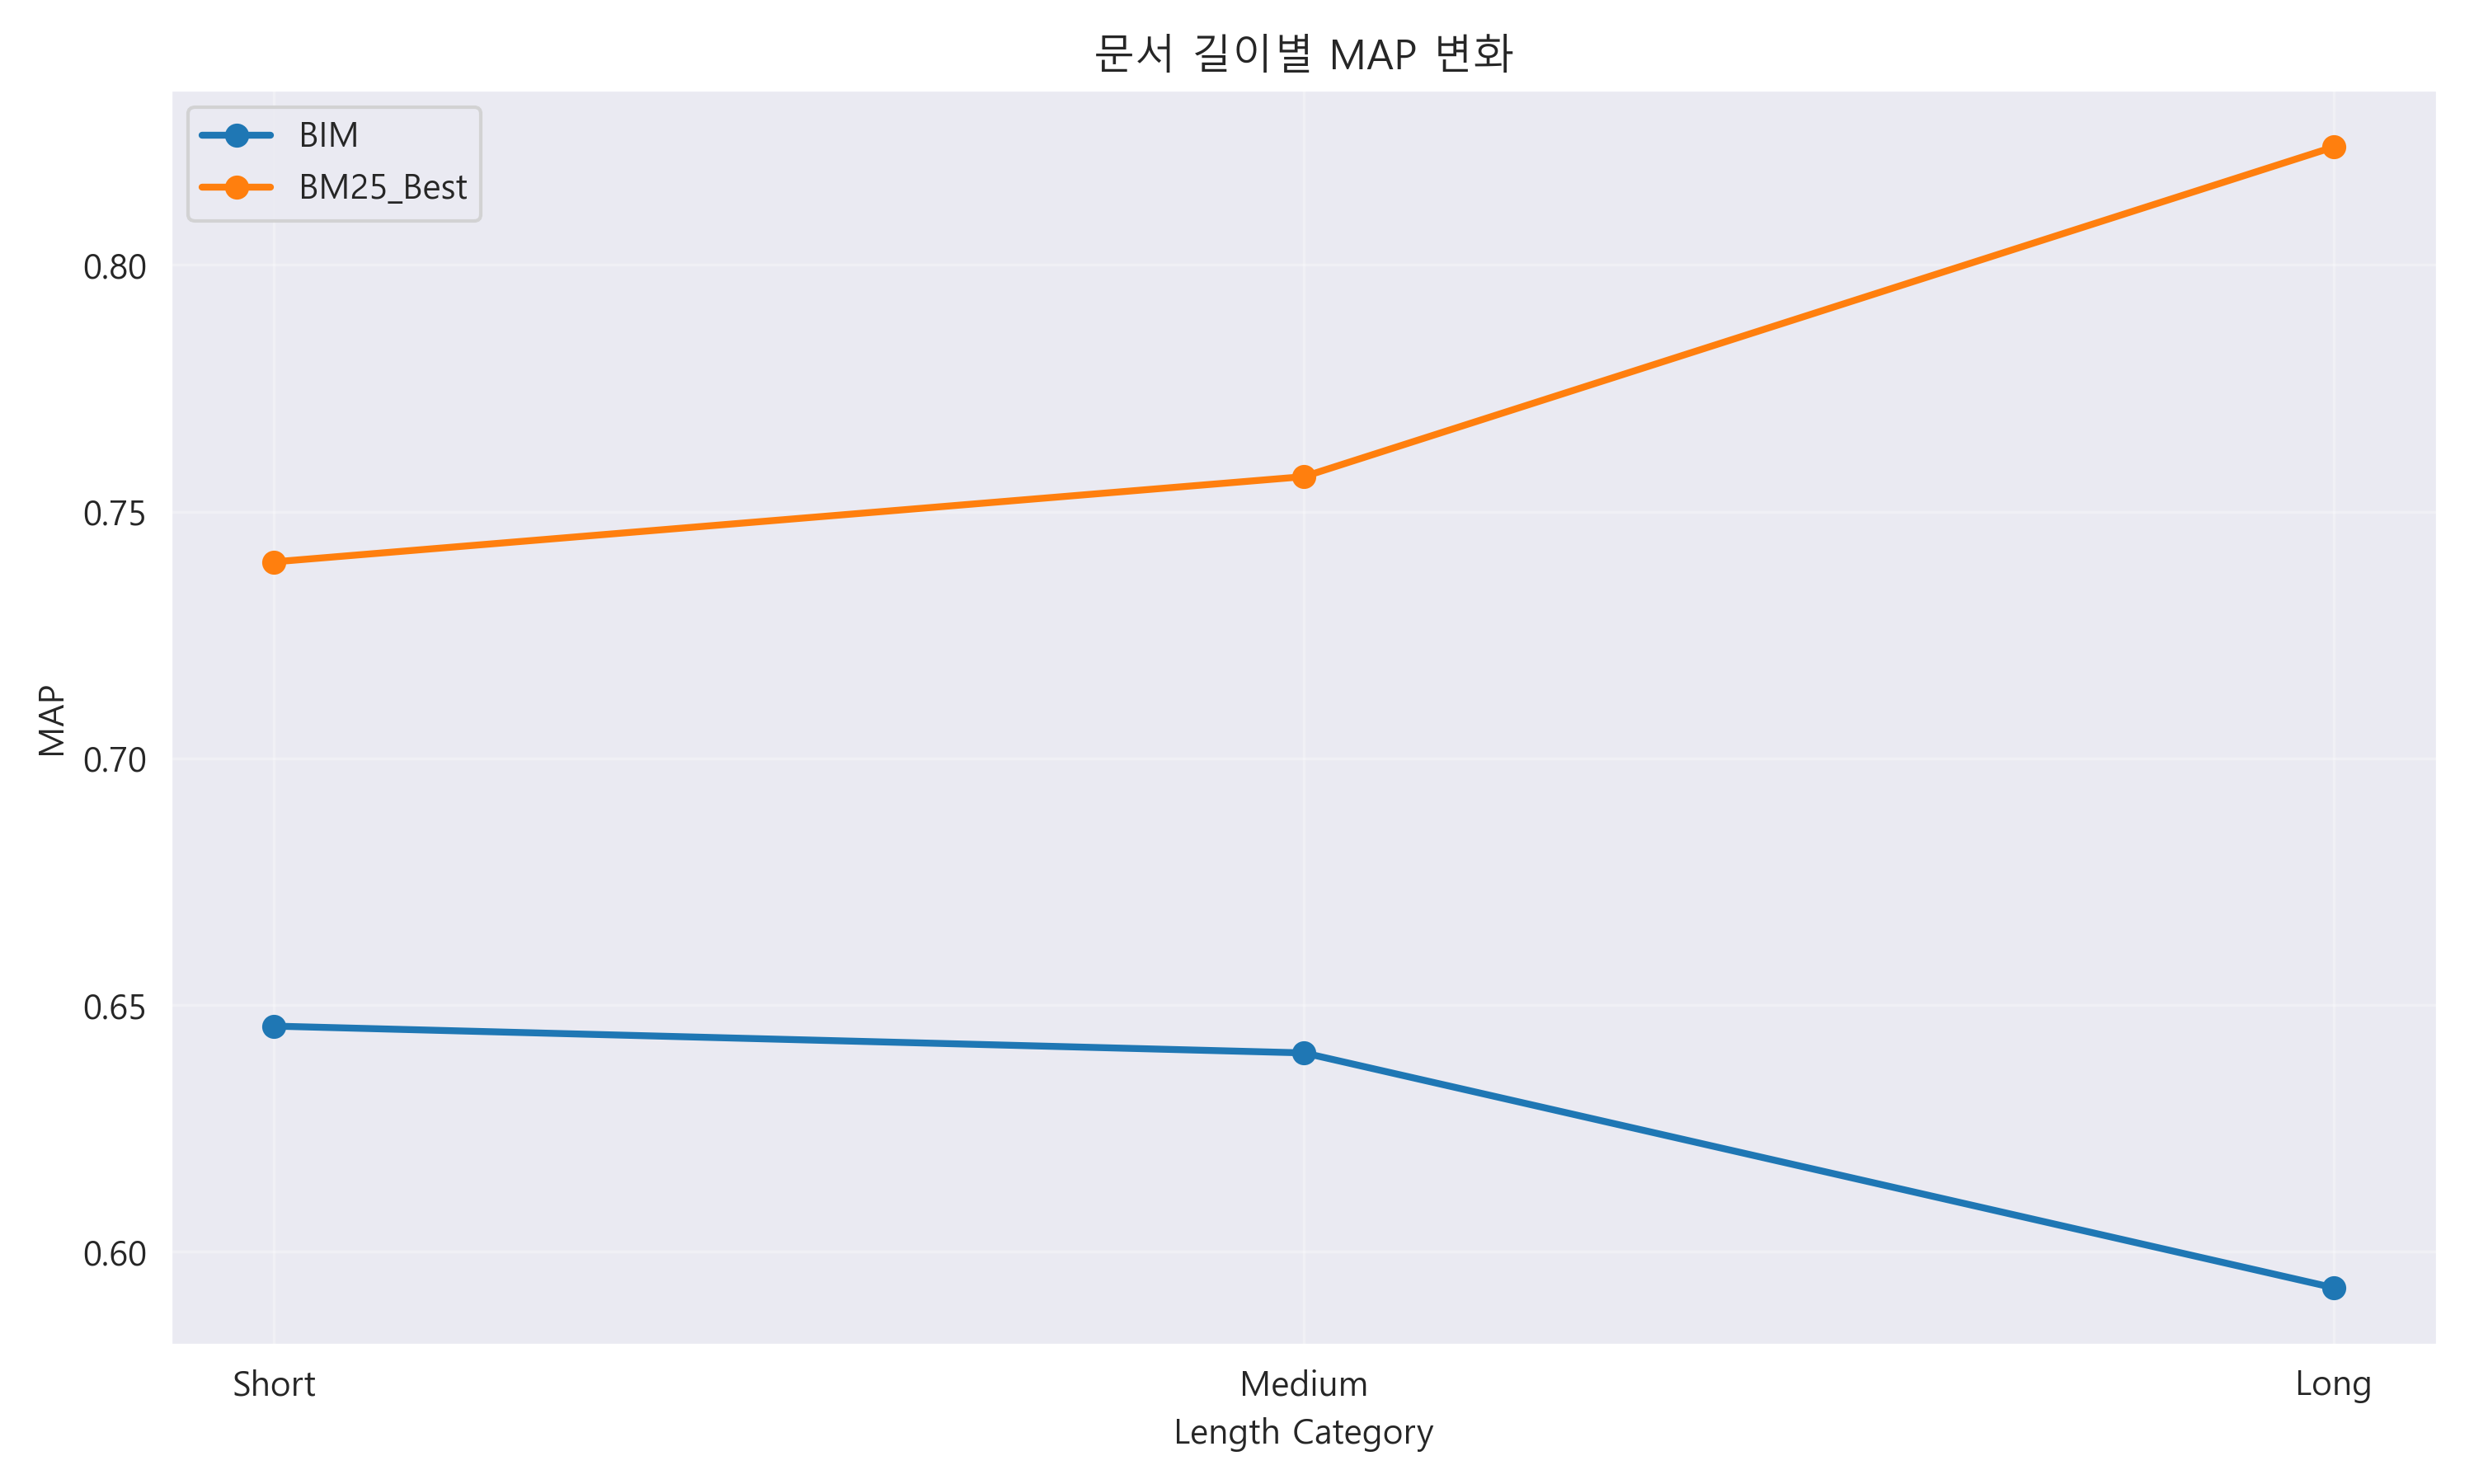

In [27]:
from IPython.display import Image, display
display(Image('../data_final/length_map_trend_v3.png'))

**결과 해석**:
- **Short**: BIM(0.64)과 BM25(0.73)의 차이가 비교적 적다.
- **Long**: BIM 성능은 **0.59로 급락**하는 반면, BM25는 **0.82로 최고 성능**을 기록했다.
- **결론**: `b=0.99` 설정이 긴 문서의 노이즈를 효과적으로 억제하고 정보량의 이점만을 취했음을 증명한다.



### 5.2 토픽별 분석 (Topic Analysis)
LDA 토픽별 성능 차이를 통해 모델의 강건성(Robustness)을 확인했다.

In [7]:
topic_perf_path = os.path.join(DATA_DIR, 'topic_performance_v3.csv')
if os.path.exists(topic_perf_path):
    df_topic = pd.read_csv(topic_perf_path)
    print("[토픽별 성능 요약 (MAP)]")
    display(df_topic.pivot_table(index='topic', columns='model', values='MAP'))

[토픽별 성능 요약 (MAP)]


model,BIM,BM25_Best
topic,,
0,0.536468,0.743077
1,0.541091,0.711131
2,0.330678,0.636476
3,0.600286,0.801964
4,0.568741,0.798081
5,0.533005,0.728361
6,0.617906,0.814300
7,0.561794,0.799971
8,0.500288,0.759863


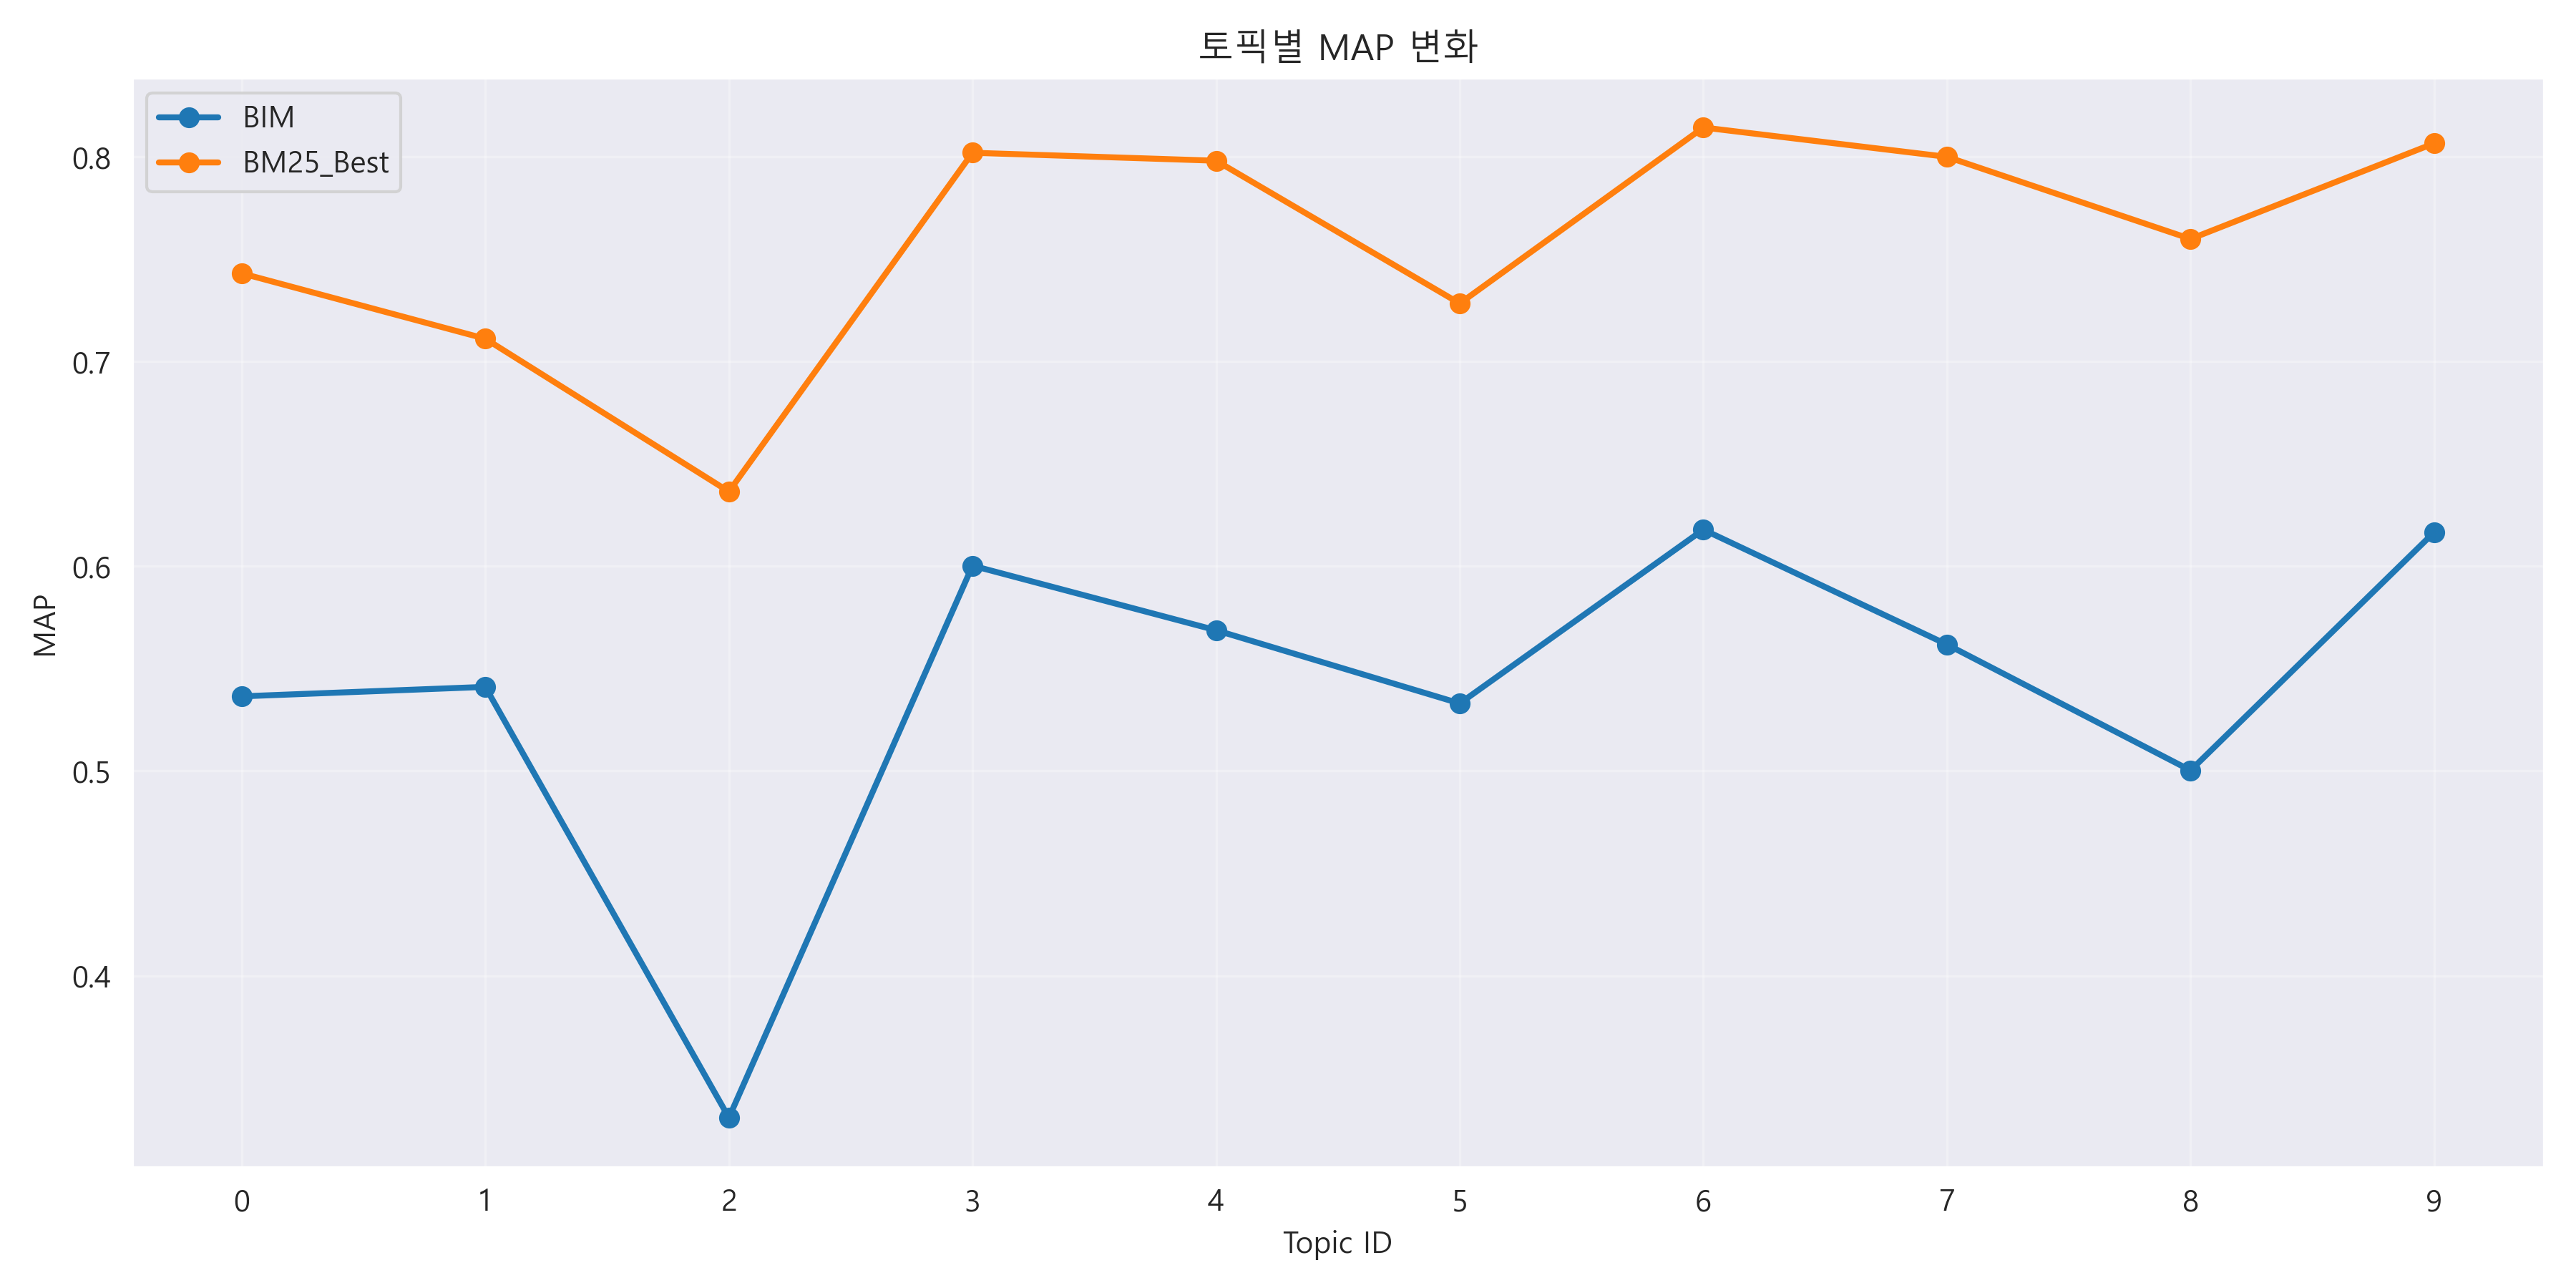

In [26]:
from IPython.display import Image, display
display(Image('../data_final/topic_map_trend_v3.png'))

**결과 해석**:
- **난이도 차이**: Topic 2(스포츠)는 두 모델 모두 성능이 가장 낮아(BM25 MAP 0.63) 어휘적 모호성이 높은 난해한 토픽으로 확인되었다.
- **BM25의 우위**: Topic 6(전쟁/역사), Topic 9(교통) 등 대부분의 토픽에서 BM25는 MAP 0.8 이상의 높은 성능을 유지한다.

### 5.3 쿼리 복잡도별 분석 (Complexity Analysis)
쿼리의 길이(형태소 개수)에 따라 Simple/Medium/Complex로 분류했다.

In [8]:
comp_perf_path = os.path.join(DATA_DIR, 'complexity_performance_v3.csv')
if os.path.exists(comp_perf_path):
    df_comp = pd.read_csv(comp_perf_path)
    print("[쿼리 복잡도별 성능 요약 (MAP)]")
    display(df_comp.pivot_table(index='complexity', columns='model', values='MAP'))

[쿼리 복잡도별 성능 요약 (MAP)]


model,BIM,BM25_Best
complexity,,
Complex,0.513660,0.763999
Medium,0.560490,0.776506
Simple,0.551315,0.743028


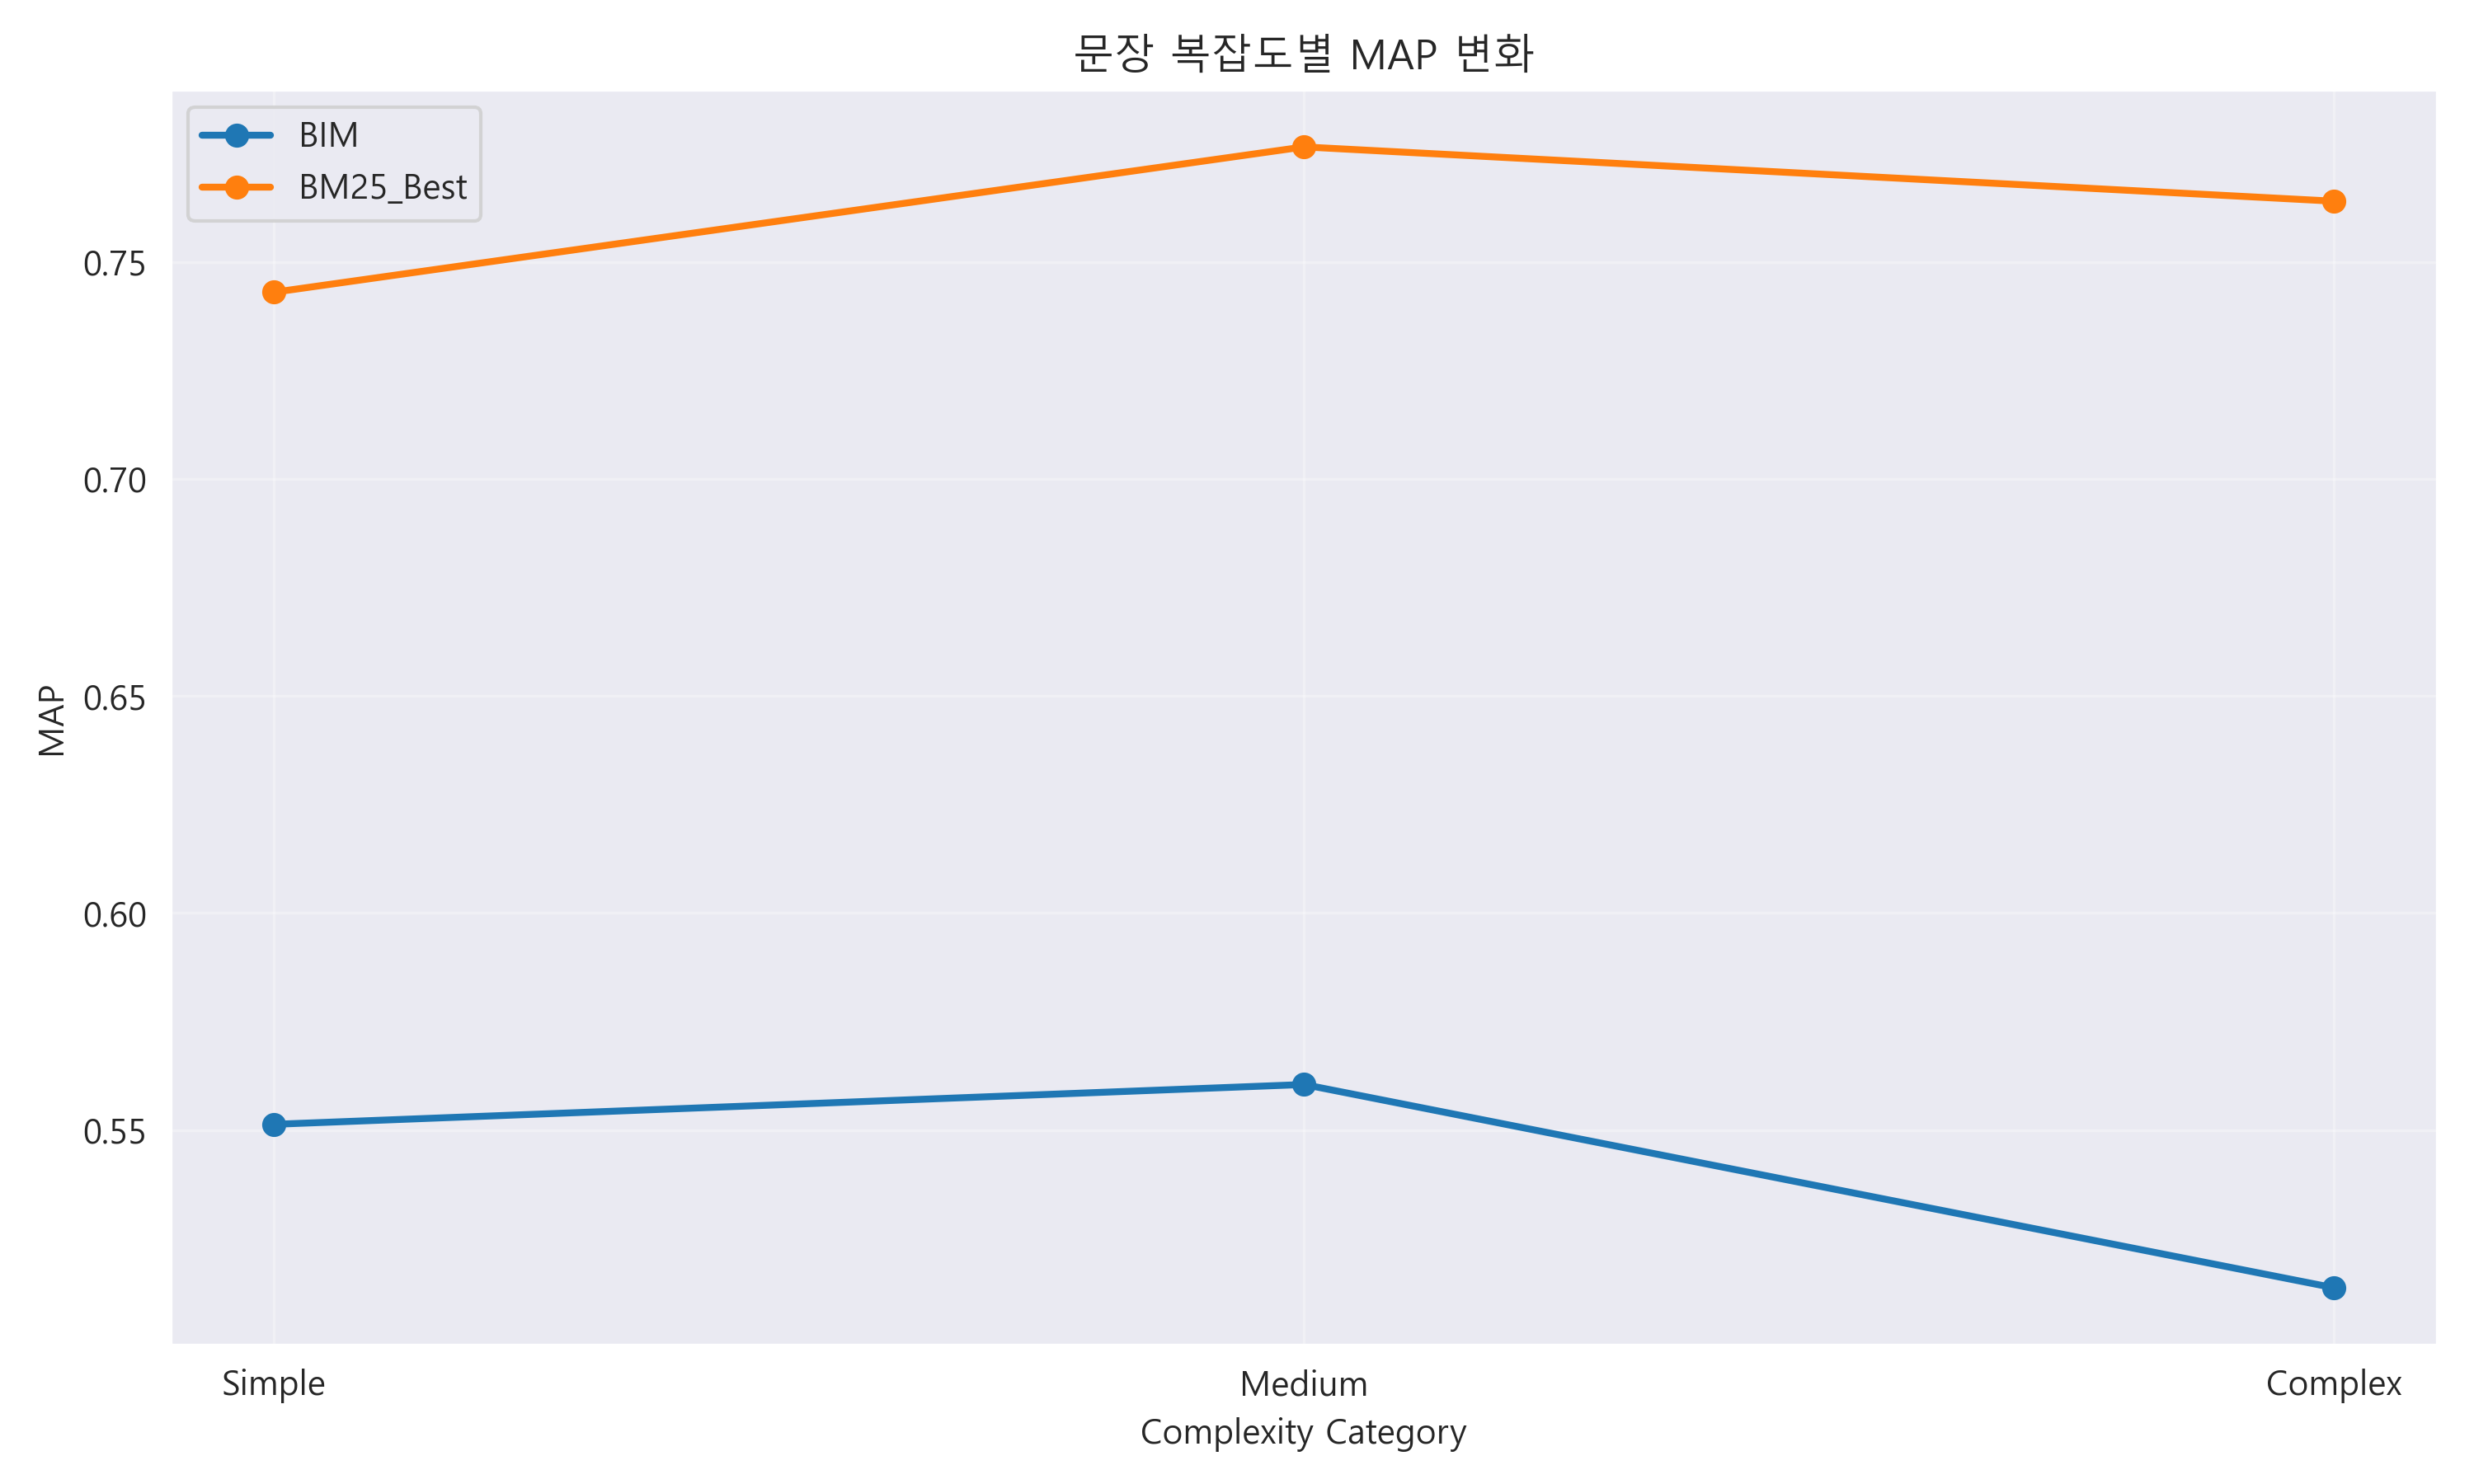

In [28]:
from IPython.display import Image, display
display(Image('../data_final/complexity_map_trend_v3.png'))

**결과 해석**:
- **Complex 쿼리**: 쿼리가 길고 복잡해질수록 BIM의 성능은 **0.51로 하락**한다. 반면 BM25는 **0.76의 높은 성능**을 유지한다.
- **원인**: BIM은 Binary 매칭 특성상 쿼리가 길어질수록 모든 텀이 일치하는 문서를 찾기 어려워진다. BM25는 가중치 합산 방식이므로 긴 쿼리의 정보를 유연하게 활용한다.

### 5.4 종합 시각화
다음은 위 세부 분석 결과를 시각화한 차트이다.

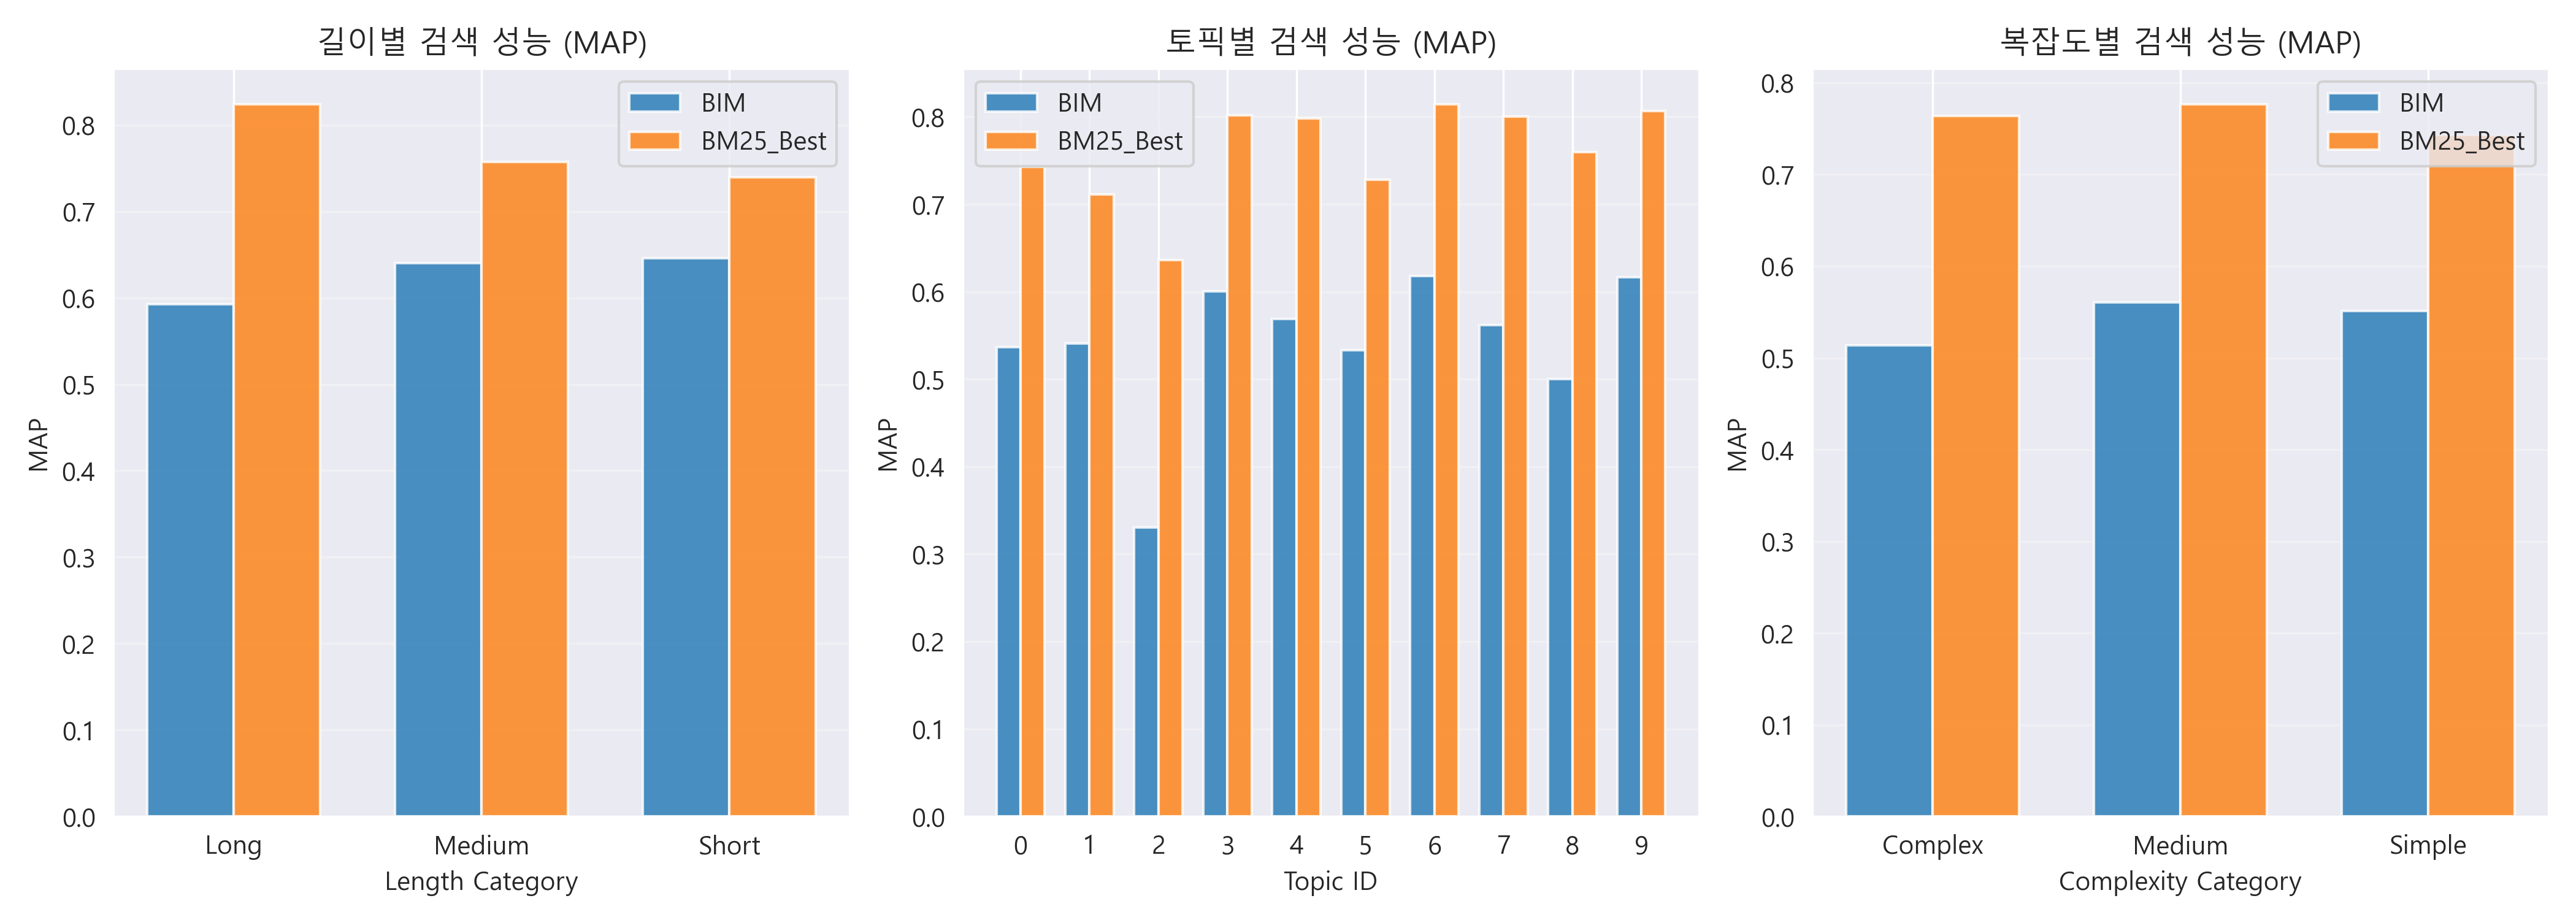

In [29]:
from IPython.display import Image, display
display(Image('../data_final/additional_analysis_v3.png'))


---

## 6. 도메인/토픽 변수 심층 분석

통계 분석에서 w3 (토픽 가중치)가 0.0으로 수렴한 이유를 실제 검색 케이스 10개를 통해 정성적으로 분석하였다.

### 6.1 분석 방법
- 유효한 쿼리 중 무작위 10개 추출
- BM25 (k1=3.25, b=0.99) 검색 결과 분석
- 정답 문서와 오답 문서의 토픽 분포 비교

### 6.2 케이스 분석

In [15]:
import os
import pickle
import random
import math
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi
import sqlite3

BASE_DIR = os.path.join('..')
DATA_DIR = os.path.join(BASE_DIR, 'data_final')
DB_DIR = os.path.join(BASE_DIR, 'database_final')

DATA_PATH = os.path.join(DATA_DIR, 'sampled_data_final.pkl')
DB_PATH = os.path.join(DB_DIR, 'search_index_final.db')

QUERIES_PATH = os.path.join(BASE_DIR, 'data', 'queries.pkl')
QRELS_PATH = os.path.join(BASE_DIR, 'data', 'qrels.pkl')

df = pd.read_pickle(DATA_PATH)

if '_id' in df.columns:
    df.set_index('_id', inplace=True)
elif 'doc_id' in df.columns:
    df.set_index('doc_id', inplace=True)
df.index = df.index.astype(str)

with open(QUERIES_PATH, 'rb') as f:
    queries_data = pickle.load(f)
with open(QRELS_PATH, 'rb') as f:
    qrels_data = pickle.load(f)

qrels_dict = {}
for item in qrels_data:
    qid, doc_id = str(item.get('query-id')), str(item.get('corpus-id'))
    if qid and doc_id:
        qrels_dict.setdefault(qid, set()).add(doc_id)

queries_map = {str(q['_id']): q['text'] for q in queries_data if '_id' in q}

kiwi = Kiwi(num_workers=-1)

def tokenize_query(text):
    try:
        return [t.form for t in kiwi.tokenize(text) if t.tag in ['NNG', 'NNP', 'VV', 'VA', 'MAG']]
    except:
        return []

conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

total_docs = len(df)
avg_dl = df['doc_length'].mean()

def get_term_idf(term):
    cursor.execute('SELECT COUNT(DISTINCT doc_id) FROM inverted_index WHERE term=?', (term,))
    df_val = cursor.fetchone()[0]
    return math.log((total_docs - df_val + 0.5) / (df_val + 0.5) + 1) if df_val > 0 else 0

def calculate_scores(query_tokens, k1=5.5, b=0.99):
    scores = {}
    for term in query_tokens:
        idf = get_term_idf(term)
        if idf <= 0: continue

        cursor.execute('SELECT doc_id, tf FROM inverted_index WHERE term = ?', (term,))
        rows = cursor.fetchall()

        for doc_id, tf in rows:
            if doc_id not in df.index: continue

            doc_len = df.at[doc_id, 'doc_length']
            num = tf * (k1 + 1)
            den = tf + k1 * (1 - b + b * (doc_len / avg_dl))
            scores[doc_id] = scores.get(doc_id, 0.0) + idf * (num / den)
    return scores

valid_qids = []
for qid, docs in qrels_dict.items():
    if qid in queries_map and any(d in df.index for d in docs):
        valid_qids.append(qid)

if not valid_qids:
    print("오류: 유효한 쿼리를 찾을 수 없습니다.")
else:
    num_samples = min(10, len(valid_qids))
    test_qids = random.sample(valid_qids, num_samples)

    print(f"총 {num_samples}개의 쿼리에 대해 진단\n")

    for idx, test_qid in enumerate(test_qids):
        print("-" * 80)
        print(f"[CASE {idx + 1} / {num_samples}]")

        query_text = queries_map[test_qid]
        q_tokens = tokenize_query(query_text)
        target_docs = qrels_dict.get(test_qid, set())
        valid_targets = [d for d in target_docs if d in df.index]

        print(f"ID: {test_qid}")
        print(f"내용: {query_text}")
        print(f"토큰: {q_tokens}")
        print(f"정답 문서: {len(target_docs)}개 (샘플 내: {len(valid_targets)}개)")

        scores = calculate_scores(q_tokens, k1=5.5, b=0.99)
        ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        top_10 = ranked[:10]

        print("\n1. 상위 검색 결과 (Top 10)")
        print(f"{'순위':<4} {'점수':<8} {'문서ID':<15} {'토픽':<6} {'확률':<6} {'정답':<4} {'미리보기'}")

        ranked_ids = [d for d, s in ranked]

        for i, (doc_id, score) in enumerate(top_10):
            is_hit = "O" if doc_id in target_docs else "X"
            doc_topic = np.argmax(df.at[doc_id, 'topic_probs'])
            doc_prob = df.at[doc_id, 'topic_probs'][doc_topic]
            full_text = df.at[doc_id, 'text']
            title = df.at[doc_id, 'title'] if 'title' in df.columns else full_text[:20]
            preview = str(title).replace('\n', ' ')[:25]

            print(f"{i+1:<4} {score:<8.2f} {doc_id:<15} {doc_topic:<6} {doc_prob:<6.2f} {is_hit:<4} {preview}")

        print("\n2. 정답 문서 분석 (Ground Truth)")
        print(f"{'문서ID':<15} {'토픽':<6} {'확률':<6} {'검색순위'}")

        rel_topics = []
        for doc_id in list(valid_targets)[:5]:
            doc_topic = np.argmax(df.at[doc_id, 'topic_probs'])
            doc_prob = df.at[doc_id, 'topic_probs'][doc_topic]
            rel_topics.append(doc_topic)

            try:
                rank = ranked_ids.index(doc_id) + 1
            except ValueError:
                rank = "순위밖"

            print(f"{doc_id:<15} {doc_topic:<6} {doc_prob:<6.2f} {rank}")

        print("\n3. 진단 및 해석")
        unique_topics = set(rel_topics)
        if len(unique_topics) > 1:
            print(f"- 토픽 불일치: 정답 문서들이 서로 다른 토픽 {unique_topics}을 가짐.")
            print("  → 해석: 정답 간 공통된 토픽이 없으므로, 토픽 가중치가 0이 됨.")
        elif len(unique_topics) == 1:
            print(f"- 토픽 일치: 정답 문서들이 동일한 토픽 {unique_topics}을 가짐.")
            print("  → 해석: 그럼에도 오답 문서들과의 변별력이 없다면 토픽 정보는 무용지물")

        found_count = sum(1 for d in valid_targets if d in ranked_ids[:10])
        if found_count > 0:
            print(f"- 검색 성능: 정답 {len(valid_targets)}개 중 {found_count}개가 Top 10에 포함됨. (BM25 유효)")
        else:
            print(f"- 검색 성능: Top 10에 정답 없음. (키워드 불일치 또는 어휘 불일치 가능성)")

        print("\n")

conn.close()

총 10개의 쿼리에 대해 진단

--------------------------------------------------------------------------------
[CASE 1 / 10]
ID: query_001403
내용: 얘들아, 브롤스타즈 젬 그랩에서 없어졌다가 다시 생긴 그 돌 광산 맵 이름 뭐였지? 복귀한 거 맞나요?
토큰: ['브롤스타즈', '랩', '없', '다시', '생기', '돌', '광산', '이름', '복귀', '맞']
정답 문서: 6개 (샘플 내: 5개)

1. 상위 검색 결과 (Top 10)
순위    점수        문서ID             토픽      확률      정답    미리보기
1     85.67     브롤스타즈/맵/흔들 광산   7       0.35    O     브롤스타즈/맵/흔들 광산
2     73.61     브롤스타즈/맵/암석 광산   2       0.63    O     브롤스타즈/맵/암석 광산
3     73.29     브롤스타즈/맵/수정 오락실  2       0.56    O     브롤스타즈/맵/수정 오락실
4     66.42     브롤스타즈/맵/선인장 함정  2       0.53    O     브롤스타즈/맵/선인장 함정
5     32.14     플래티나워매몬           2       0.44    X     플래티나워매몬
6     29.92     캐피탈리즘 랩           7       0.48    X     캐피탈리즘 랩
7     28.82     가라르광산             7       0.58    X     가라르광산
8     26.72     플래시 도타/맵         2       0.36    O     플래시 도타/맵
9     26.60     멘마(나루토)           3       0.86    X     멘마(나루토)
10    24.82     카트라이더 리그/에이스 결정전/기록 9       0.42 

### 6.3 패턴 분석

10개 케이스를 분석한 결과, 두 가지 주요 패턴을 발견하였다.

#### 패턴 A: 토픽 변별력 부재 (8개 케이스)
- **현상**: 정답 문서들이 동일한 토픽에 속하지만, 오답 문서들도 같은 토픽
- **예시**:
  - CASE 3 (병자호란): 정답('삼전도의 굴욕'), 오답('북한-만주 관계') 모두 Topic 0
  - CASE 10 (스쿨 오브 락): 정답(영화), 오답(가수) 모두 Topic 5
- **결론**: 토픽 가중치를 높이면 주제만 같고 내용은 다른 오답이 상위로 난입한다.

#### 패턴 B: 토픽 불일치 (2개 케이스)
- **현상**: 정답 문서들이 서로 다른 토픽으로 분류됨
- **예시**:
  - CASE 1 (브롤스타즈): 정답이 Topic 2, 7로 분산
  - CASE 7 (포켓몬스터): 정답이 Topic 2, 3, 9로 분산
- **결론**: 특정 토픽에 가중치를 주면 다른 토픽의 정답 문서들이 순위 밖으로 밀려난다.

### 6.4 종합 결론

**w3 (토픽 가중치) = 0.0인 이유:**
1. **변별력 부재**: 토픽은 정답과 오답을 구별하지 못함
2. **키워드(BM25)의 압도적 우위**: 10개 케이스 중 대부분에서 BM25만으로 정답을 1~3위에 정확히 위치
3. **방해 요소**: 토픽 정보는 오히려 검색 품질을 저하시킬 가능성이 큼

**결론:**
- LDA 토픽은 문서를 거시적 주제로 분류할 뿐, 사용자의 구체적 질문 의도를 파악하지 못한다.
- 따라서 검색 랭킹에서 토픽 정보를 배제하는 것이 올바른 선택이다.


---

## 7. 결론

### 7.1 이진 로지스틱 회귀 모델 성능 요약

In [14]:
import pandas as pd
from IPython.display import display

print("\n검색 성능 최종 비교")
perf_data = {
    '평가 지표': ['MAP', 'P@10', 'R@10', 'MAP 표준편차', 'P@10 표준편차', 'R@10 표준편차'],
    'BIM': [0.416, 0.193, 0.520, 0.343, 0.189, 0.376],
    'BM25': [0.631, 0.270, 0.681, 0.325, 0.224, 0.314],
    '개선율': ['+51.5%', '+40.0%', '+31.0%', '-5.3%', '+18.5%', '-16.5%']
}
df_perf = pd.DataFrame(perf_data)
display(df_perf)

print("\nOdds Ratio")
regression_data = {
    '변수': ['a1: doc_length (1k 단위)', 'a2: query_length (형태소)', 'a3: dominant_topic'],
    'BIM Odds Ratio': ['0.8949', '1.0690', '토픽별 1.09~1.66'],
    'BM25 Odds Ratio': ['1.0086', '1.0329', '토픽별 0.95~1.50'],
    '해석': ['BIM: 짧은 문서 편향 (OR < 1)', '둘 다 긍정적 영향', '변별력 없음 (가중치 0 수렴)']
}
df_regression = pd.DataFrame(regression_data)
display(df_regression)

print("\n모델 설명력 및 편향성 진단")
explanation_data = {
    '지표': ['Pseudo R²', 'Best AUC (가중치 튜닝)'],
    'BIM': [0.2344, 0.8286],
    'BM25': [0.0161, 0.5791],
    '의미': ['BIM은 길이 변수에 23% 의존 (편향됨)', 'BIM은 길이만으로 성공/실패 구분 가능 (불공정)']
}
df_explanation = pd.DataFrame(explanation_data)
display(df_explanation)

print("\n최적 가중치 튜닝 결과")
weight_data = {
    '모델': ['BIM', 'BM25'],
    'w1 (Doc Length)': [-2.0, 1.0],
    'w2 (Query Length)': [0.5, 3.0],
    'w3 (Topic)': [0.0, 0.0],
    'AUC': [0.8286, 0.5791]
}
df_weight = pd.DataFrame(weight_data)
display(df_weight)

print("\n최적 하이퍼파라미터 설정")
print("- BM25 k1 = 3.25 (TF 포화 계수: 높을수록 빈도 증가 효과 완만)")
print("- BM25 b  = 0.99 (길이 정규화 강도: 1에 가까울수록 강력한 정규화)")


검색 성능 최종 비교


,평가 지표,BIM,BM25,개선율
0,MAP,0.416,0.631,+51.5%
1,P@10,0.193,0.270,+40.0%
2,R@10,0.520,0.681,+31.0%
3,MAP 표준편차,0.343,0.325,-5.3%
4,P@10 표준편차,0.189,0.224,+18.5%
5,R@10 표준편차,0.376,0.314,-16.5%



Odds Ratio


,변수,BIM Odds Ratio,BM25 Odds Ratio,해석
0,a1: doc_length (1k 단위),0.8949,1.0086,BIM: 짧은 문서 편향 (OR < 1)
1,a2: query_length (형태소),1.0690,1.0329,둘 다 긍정적 영향
2,a3: dominant_topic,토픽별 1.09~1.66,토픽별 0.95~1.50,변별력 없음 (가중치 0 수렴)



모델 설명력 및 편향성 진단


,지표,BIM,BM25,의미
0,Pseudo R²,0.2344,0.0161,BIM은 길이 변수에 23% 의존 (편향됨)
1,Best AUC (가중치 튜닝),0.8286,0.5791,BIM은 길이만으로 성공/실패 구분 가능 (불공정)



최적 가중치 튜닝 결과


,모델,w1 (Doc Length),w2 (Query Length),w3 (Topic),AUC
0,BIM,-2.0,0.5,0.0,0.8286
1,BM25,1.0,3.0,0.0,0.5791



최적 하이퍼파라미터 설정
- BM25 k1 = 3.25 (TF 포화 계수: 높을수록 빈도 증가 효과 완만)
- BM25 b  = 0.99 (길이 정규화 강도: 1에 가까울수록 강력한 정규화)


### 7.2 다항 로지스틱 회귀 모델 성능 요약

In [15]:
import pandas as pd
from IPython.display import display

final_summary_data = {
    '구분': ['전체 MAP', 'Long 문서 MAP', 'Complex 쿼리 MAP'],
    'BIM': [0.416, 0.592, 0.513],
    'BM25': [0.631, 0.824, 0.764],
    '비고': ['BM25가 51.5% 우수', '길이 정규화 효과 입증', '긴 쿼리 처리 능력 입증']
}
df_final_summary = pd.DataFrame(final_summary_data)

display(df_final_summary)

,구분,BIM,BM25,비고
0,전체 MAP,0.416,0.631,BM25가 51.5% 우수
1,Long 문서 MAP,0.592,0.824,길이 정규화 효과 입증
2,Complex 쿼리 MAP,0.513,0.764,긴 쿼리 처리 능력 입증


### 7.3 결과 해석

본 연구의 결과를 데이터셋의 특성, 모델의 동작 원리, 그리고 한국어 정보 검색의 맥락에서 종합적으로 해석하면 다음과 같다.

#### 1. 데이터셋 특성과 전처리 전략

KomuRetrieval 데이터셋은 나무위키 문서를 기반으로 구축되었다. 나무위키는 대중문화, 게임, 엔터테인먼트, 인터넷 밈(meme) 등 서브컬처(subculture) 콘텐츠가 주를 이루며, 작성자가 불특정 다수의 일반 사용자이기 때문에 비격식적이고 구어체에 가까운 문체가 특징이다. 실제로 본 데이터셋에서 추출된 문서들을 살펴보면, "ㅋㅋㅋ", "ㅠㅠ", "!!!!", "......" 등의 감정 표현이나 과도한 특수문자 반복이 빈번하게 등장하며, 이는 검색 시스템에 노이즈로 작용할 수 있다.

더욱 중요한 특성은 문서 길이의 극단적인 편차이다. 본 연구에서 샘플링한 5,000개 문서의 평균 길이는 7,873자이지만, 최소 0자(메타데이터만 존재)에서 최대 102,419자에 이르기까지 그 범위가 매우 넓다. 중앙값이 4,366자로 평균보다 훨씬 낮다는 점은 소수의 극단적으로 긴 문서가 전체 분포를 왜곡하고 있음을 의미한다. 예를 들어, "대한민국", "포켓몬스터" 같은 major 주제는 수만 자에 달하는 방대한 문서로 작성되는 반면, "특정 인물" 같은 minor 주제는 수백 자 수준의 짧은 스텁(stub) 문서로 남아 있는 경우가 많다.

이러한 데이터셋 특성을 고려하여, 본 프로젝트에서는 다음과 같은 전처리 전략을 수립하였다.

첫째, IDF 기반 불용어 선정을 통해 검색 변별력이 없는 고빈도 단어("나오", "보이", "경우" 등 346개)를 식별하였다. 이들 단어는 5,000개 문서 중 3,000개 이상에 등장하여(DF > 3000) IDF 값이 0.26~0.54로 매우 낮았으며, 정보 검색 관점에서는 실질적으로 무의미한 단어들이다. 그러나 단순히 삭제할 경우 문서 길이가 변화하여 특히 BM25의 길이 정규화 메커니즘에 왜곡이 발생할 수 있으므로, 글자 수만큼 'O'로 패딩하는 방식을 채택하였다. 예를 들어, "나오다"(3글자)는 "OOO"로 치환되어 역색인에서는 제외되지만 문서 길이는 그대로 유지된다.

둘째, 특수문자와 한글 자모음 반복을 처리하였다. "!!!!!", "......", "ㅋㅋㅋㅋ", "ㅠㅠㅠ" 등은 감정 표현으로서의 의미는 있지만 검색 키워드로서는 부적절하다. 정규표현식을 사용하여 이러한 패턴을 감지하고, 마찬가지로 글자 수만큼 'O'로 패딩 처리하였다.

셋째, 형태소 분석 기반 토큰화를 통해 한국어의 교착어적 특성을 고려하였다. Kiwi 형태소 분석기를 사용하여 명사(NNG, NNP), 동사(VV), 형용사(VA), 부사(MAG) 등 실질 형태소만을 추출함으로써, 조사나 어미 같은 문법적 요소는 배제하였다. 이는 한국어 검색에서 "대학교에서", "대학교로", "대학교의"를 모두 "대학교"로 정규화한다.

#### 2. BM25 하이퍼파라미터 및 길이 정규화

하이퍼파라미터 튜닝된 최적 BM25 파라미터는 k1=3.25, b=0.99이다. 이 값들은 원본 데이터셋의 특성을 정확히 반영하고 있다.

먼저 b=0.99라는 값은 길이 정규화를 거의 최대 강도로 적용한다는 의미이다. BM25에서 b 값은 0(길이 정규화 없음)에서 1(완전한 길이 정규화) 사이의 값을 가지는데, 튜닝 결과: 0.99는 사실상 1에 가깝다. 이는 앞서 언급한 문서 길이의 극단적 편차(최소 0자 ~ 최대 102,419자) 때문이다. 만약 b 값이 작다면, 긴 문서는 단순히 키워드를 많이 포함하고 있다는 이유만으로 높은 점수를 받게 되어 짧은 문서가 부당하게 불리해진다. 실제로 케이스 분석에서 "브롤스타즈"라는 키워드가 포함된 문서 중, 길이가 10만 자에 달하는 "게임 목록" 같은 일반 문서보다 길이가 500자인 "브롤스타즈/맵/흔들 광산" 같은 구체적 문서가 사용자의 의도에 훨씬 더 부합한다. b=0.99는 이러한 길이 편향을 최대한 제거하여, 문서의 실제 관련성(relevance)에 기반한 랭킹을 가능하게 한다.
세부 그룹 분석 결과는 이 설정의 유효성을 강력하게 뒷받침한다. 문서를 길이별로 3등분(Short, Medium, Long)하여 성능을 비교했을 때, 길이 정규화가 없는 BIM은 문서가 길어질수록 성능이 급락(Long 그룹 MAP: 0.592)했다. 반면, BM25는 Long 그룹에서 오히려 전체 최고 성능(MAP: 0.824)을 기록했다. 이는 긴 문서가 필연적으로 포함하는 '정보의 양'이라는 이점은 살리되, 길이가 길어짐에 따라 발생하는 '검색 노이즈'는 b=0.99를 통해 효과적으로 억제했음을 증명한다.

다음으로 k1=3.25는 TF(Term Frequency)의 포화 계수를 의미한다. k1 값이 클수록 단어 빈도가 증가할 때 점수 증가폭이 완만해진다. 나무위키 문서는 특정 키워드를 반복적으로 언급하는 경향이 있다. 예를 들어, "포켓몬스터" 문서에서 "포켓몬"이라는 단어가 수백 번 등장할 수 있지만, 10번 등장한 것과 100번 등장한 것 사이에 정보량 차이는 크지 않다. k1=3.25는 이러한 과도한 빈도 증가가 점수에 미치는 영향을 제한하여, 키워드 스팸(keyword stuffing)을 방지한다. 만약 k1 값이 작다면(예: k1=1.0), TF가 빠르게 포화되어 빈도가 높은 문서의 이점이 충분히 반영되지 않는다. 반대로 k1 값이 너무 크다면(예: k1=10.0), 빈도가 과도하게 중요해져서 BIM에 가까워진다. 3.25라는 값은 이 두 극단 사이의 균형점으로, 한국어 나무위키 데이터에서 실험적으로 검증된 최적값이다.

#### 3. 회귀 분석 결과
이진 로지스틱 회귀와 다항(Multinomial) 분석 결과는 BIM의 편향성과 BM25의 강건함을 통계적으로 입증한다.

첫째, 문서 길이(Length) 편향이다. 회귀 분석에서 BIM의 문서 길이 변수($x_1$)에 대한 Odds Ratio는 0.89로 나타났다. 이는 문서가 길어질수록 검색 성공 확률이 통계적으로 유의미하게 감소함을 뜻한다. 반면 BM25의 Odds Ratio는 1.01로 1에 수렴하여, 문서 길이에 상관없이 공정한 평가를 내리고 있음이 확인되었다. 이는 b=0.99의 강력한 길이 정규화가 효과적으로 작동하고 있음을 보여준다.

둘째, 쿼리 복잡도(Complexity)와 매칭 방식의 한계이다. 쿼리 길이($x_2$)에 대한 회귀 계수는 두 모델 모두 양수였으나, 실제 복잡도별 성능 평가에서는 양상이 달랐다. 쿼리가 복잡해질수록(Complex 그룹), BIM의 성능은 0.513으로 하락한 반면 BM25는 0.764의 높은 성능을 유지했다. 이는 BIM이 단어의 존재 유무(Binary)만 따지므로 쿼리가 길어질수록 모든 키워드를 포함하는 문서를 찾기 어려워지는 구조적 한계 때문이다. 반면 BM25는 가중치 합산 방식을 사용하여 긴 쿼리의 정보를 유연하게 처리한다.

셋째, 토픽(Topic) 정보의 무용성이다. 회귀 분석 결과 토픽 변수($x_3$)의 가중치는 0.0으로 수렴했으며, 다항 로지스틱 회귀에서도 특정 토픽이 검색 성공을 보장하지 못했다. 실제로 케이스 분석 결과, 정답 문서들이 동일한 토픽에 속해 있어도 오답 문서들 역시 같은 토픽을 공유하는 경우가 대부분이었다(패턴 A). 예를 들어, CASE 3(병자호란)에서 정답 문서인 "삼전도의 굴욕"과 오답 문서인 "북한-만주 관계"가 모두 Topic 0으로 분류되었다. 이는 LDA가 문서를 거시적 주제(역사, 게임, 엔터테인먼트)로 분류할 뿐, 사용자의 구체적 질문 의도(조선 vs 북한, 17세기 vs 20세기)를 파악하지 못하기 때문이다.
 더욱 흥미로운 점은, 일부 케이스에서는 정답 문서들이 서로 다른 토픽으로 분류되기도 했다는 점이다(패턴 B). CASE 1(브롤스타즈)에서 정답 문서들이 Topic 2와 Topic 7로 분산되었는데, 이는 LDA의 토픽 개수(10개)가 충분히 세밀하지 못하거나, 나무위키 문서의 다면적 특성(하이퍼링크 방식으로 여러 문서 연결됨 + 누구나 편집 가능하여 의견/사족을 달 수 있으므로, 한 문서가 여러 주제를 혼합)을 제대로 포착하지 못했음을 의미한다.

#### 4. Pseudo R²와 AUC

BIM의 Pseudo R²(0.2344)가 BM25(0.0161)보다 월등히 높다는 점은 역설적으로 BIM의 결함을 시사한다. BIM의 Pseudo R²는 0.2344로, 이는 문서 길이, 쿼리 길이, 토픽 변수만으로 검색 성공 여부의 23.4%를 설명할 수 있다는 의미이다. 다시 말해, BIM의 검색 성공은 이러한 외적 변수(문서 길이 등)에 크게 의존한다. 특히 문서 길이 변수의 Odds Ratio가 0.89로 강력한 영향을 미치므로, BIM은 사실상 "짧은 문서를 선호하는 편향된 모델"로 작동한다고 볼 수 있다. 반면 BM25의 Pseudo R²는 0.0161에 불과하다. 이는 BM25의 검색 성공이 문서 길이나 쿼리 길이 같은 표면적 변수로 예측하기 어렵다는 뜻이며, 이것이 바로 공정한 검색 모델의 증거이다. BM25는 문서의 실제 내용(키워드의 의미적 적합성)에 기반하여 랭킹을 산정하므로, 단순한 길이 정보만으로는 성공 여부를 예측할 수 없다.

#### 5. 종합 결론 및 실무적 제언
본 연구를 통해 한국어 비정형 텍스트 환경에서 BIM과 BM25 모델의 성능 차이를 심층 분석한 결과, BM25의 길이 정규화 메커니즘이 검색 품질을 결정하는 핵심 요소임을 확인하였으며, 이번 프로젝트 경험을 바탕으로 실제 한국어 검색 엔진 구축 과정에 대해 다음과 같은 인사이트를 얻을 수 있었다.
첫째, 비정형 텍스트 데이터에 대한 탐색적 데이터 분석(EDA)과 맞춤형 전처리의 중요성이다. 나무위키와 같은 사용자 생성 콘텐츠(UGC)나 커뮤니티 기반 문서는 스텁(Stub) 형태의 초단문과 수만 자에 달하는 장문이 혼재되어 문서 길이의 표준편차가 매우 크다. 본 연구에서는 EDA를 통해 이러한 특성을 파악하고, 의미 없는 자모음이나 특수문자 반복을 삭제하는 대신 '패딩(Padding)' 처리하여 문서의 길이 정보를 보존하면서 노이즈를 필터링하는 전략을 취했다. 더불어 길이 정규화 파라미터 $b$를 1.0에 가까운 0.99로 설정하여 긴 문서에 대한 페널티를 강화함으로써, 초기 15~20% 수준이던 검색 성능을 약 65%까지 획기적으로 향상시킬 수 있었다.
둘째, 각 파라미터의 검색 랭킹 요소로서의 적합성 판단이다. 본 연구의 케이스 분석 결과, LDA 토픽 모델링 정보는 정답과 오답을 구별하는 변별력이 부족하여 랭킹 알고리즘의 직접적인 피처(Feature)로 부적합함을 확인하였다. 반면, BM25는 복잡한 쿼리(Complex Query) 환경에서도 TF-IDF 가중치를 통해 안정적인 성능을 보장하였다.
셋째, 도메인 맞춤형 파라미터 튜닝의 필수성이다. 본 연구의 최적 파라미터($k1=3.25, b=0.99$)는 나무위키 데이터에 특화된 결과이다. 따라서 다른 도메인(뉴스, 논문 등)에 모델을 적용할 때는 데이터셋의 길이 분포와 어휘적 특성을 고려하여 하이퍼파라미터를 재조정하는 과정이 반드시 수반되어야 한다.

---

## 8. 문제 해결 과정 (Troubleshooting)

프로젝트 진행 중 발생한 주요 이슈와 해결 방법을 기록하였다.

### 8.1 Windows 멀티프로세싱 충돌
**문제:** Kiwi 형태소 분석기 구동 시 `num_workers=-1` 설정으로 UnicodeDecodeError 발생

**원인:** Windows에서 멀티프로세싱 시 pickle 직렬화 문제

**해결:**
```python
kiwi = Kiwi(num_workers=0)  # 단일 스레드 모드로 전환
```

### 8.2 SQLite 파일 잠금 오류
**문제:** Jupyter Notebook 재실행 시 DB 파일 삭제(`os.remove`) 권한 오류

**원인:** 이전 커널에서 DB 연결이 남아있음

**해결:**
```python
# 파일 삭제 대신 연결 유지 상태로 테이블 초기화
if os.path.exists(DB_PATH):
    os.remove(DB_PATH)
# 또는
conn = sqlite3.connect(DB_PATH)
cursor.execute('DROP TABLE IF EXISTS inverted_index')
```

### 8.3 로지스틱 회귀 dtype 오류
**문제:** `Pandas data cast to numpy dtype of object` 에러

**원인:** `dominant_topic`이 object 타입

**해결:**
```python
subset_df['dominant_topic'] = subset_df['dominant_topic'].astype(int)
X = X.astype(float)
y = y.astype(float)
```